In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('/home/hrai/codes/hpe_library/')
from lib_import import *
from my_utils import *

### Load dataset

In [2]:
h36m_3d_world, h36m_cam_param = load_h36m()

subject = 'S1'
action = 'Walking'
subject_list = h36m_3d_world._data.keys()
action_list = h36m_3d_world._data[subject].keys()
pose3d_s1_walking = h36m_3d_world._data[subject][action]['positions'] # 3d skeleton sequence wrt world CS
cam_info_s1_walking = h36m_3d_world._data[subject][action]['cameras']
cam_param_s1_walking = get_cam_param(cam_info_s1_walking, subject, h36m_cam_param)

# camera parameters
W, H = cam_param_s1_walking['54138969']['W'], cam_param_s1_walking['54138969']['H']
cam_54138969_ext = cam_param_s1_walking['54138969']['ext']
cam_54138969_int = cam_param_s1_walking['54138969']['int']
cam_54138969_proj = cam_param_s1_walking['54138969']['proj']
cam_54138969_origin = cam_param_s1_walking['54138969']['C']

# 3d trajectory
torso_trajectory = get_part_traj(pose3d_s1_walking, 'torso')
pelvis_trajectory = get_part_traj(pose3d_s1_walking, 'pelvis')
l_hip_trajectory = get_part_traj(pose3d_s1_walking, 'l_hip')
l_shoulder_trajectory = get_part_traj(pose3d_s1_walking, 'l_shoulder')
r_shoulder_trajectory = get_part_traj(pose3d_s1_walking, 'r_shoulder')
r_hip_trajectory = get_part_traj(pose3d_s1_walking, 'r_hip')
lower_line_trajectory = get_part_traj(pose3d_s1_walking, 'lower_line')

# World frame
world_frame = generate_world_frame()

==> Loading 3D data wrt World CS...


### Collect arm data

In [3]:
# 각 pose로부터 root_point, upper_vector, under_vector 모으기
l_shoulder_idx = get_h36m_keypoint_index('L_Shoulder')
r_shoulder_idx = get_h36m_keypoint_index('R_Shoulder')
l_hip_idx = get_h36m_keypoint_index('L_Hip')
r_hip_idx = get_h36m_keypoint_index('R_Hip')

root_point_traj_list = []
upper_vector_traj_list = []
under_vector_traj_list = []
for subject in subject_list:
    print(subject)
    action_list = h36m_3d_world._data[subject].keys()
    for action in action_list:
        print(action)
        pose_3d_world = h36m_3d_world._data[subject][action]['positions'] # 3d skeleton sequence wrt world CS
        l_shoulder_trajectory = get_part_traj(pose_3d_world, 'l_shoulder')[:, 0, :] # (F, 3)
        r_shoulder_trajectory = get_part_traj(pose_3d_world, 'r_shoulder')[:, 0, :]
        l_hip_trajectory = get_part_traj(pose_3d_world, 'l_hip')[:, 0, :]
        r_hip_trajectory = get_part_traj(pose_3d_world, 'r_hip')[:, 0, :]
        l_elbow_trajectory = get_part_traj(pose_3d_world, 'l_elbow')[:, 0, :]
        r_elbow_trajectory = get_part_traj(pose_3d_world, 'r_elbow')[:, 0, :]
        l_wrist_trajectory = get_part_traj(pose_3d_world, 'l_wrist')[:, 0, :]
        r_wrist_trajectory = get_part_traj(pose_3d_world, 'r_wrist')[:, 0, :]
        l_knee_trajectory = get_part_traj(pose_3d_world, 'l_knee')[:, 0, :]
        r_knee_trajectory = get_part_traj(pose_3d_world, 'r_knee')[:, 0, :]
        l_ankle_trajectory = get_part_traj(pose_3d_world, 'l_ankle')[:, 0, :]
        r_ankle_trajectory = get_part_traj(pose_3d_world, 'r_ankle')[:, 0, :]

        l_arm_upper_vector_trajectory = l_elbow_trajectory - l_shoulder_trajectory # (F, 3)
        r_arm_upper_vector_trajectory = r_elbow_trajectory - r_shoulder_trajectory
        l_arm_under_vector_trajectory = l_wrist_trajectory - l_elbow_trajectory
        r_arm_under_vector_trajectory = r_wrist_trajectory - r_elbow_trajectory
        l_leg_upper_vector_trajectory = l_knee_trajectory - l_hip_trajectory
        r_leg_upper_vector_trajectory = r_knee_trajectory - r_hip_trajectory
        l_leg_under_vector_trajectory = l_ankle_trajectory - l_knee_trajectory
        r_leg_under_vector_trajectory = r_ankle_trajectory - r_knee_trajectory

        root_point_traj_list.append(l_shoulder_trajectory)
        root_point_traj_list.append(r_shoulder_trajectory)
        root_point_traj_list.append(l_hip_trajectory)
        root_point_traj_list.append(r_hip_trajectory)
        upper_vector_traj_list.append(l_arm_upper_vector_trajectory)
        upper_vector_traj_list.append(r_arm_upper_vector_trajectory)
        upper_vector_traj_list.append(l_leg_upper_vector_trajectory)
        upper_vector_traj_list.append(r_leg_upper_vector_trajectory)
        under_vector_traj_list.append(l_arm_under_vector_trajectory)
        under_vector_traj_list.append(r_arm_under_vector_trajectory)
        under_vector_traj_list.append(l_leg_under_vector_trajectory)
        under_vector_traj_list.append(r_leg_under_vector_trajectory)

        break
    break

S1
Waiting 1


In [4]:
len(root_point_traj_list), len(upper_vector_traj_list), len(under_vector_traj_list)

(4, 4, 4)

In [5]:
# camera parameters
cam_param = {}
for camera_id in ['54138969', '55011271', '58860488', '60457274']:
    cam_param[camera_id] = {}
    cam_param[camera_id]['proj'] = cam_param_s1_walking[camera_id]['proj']
    cam_param[camera_id]['ext'] = cam_param_s1_walking[camera_id]['ext']
    cam_param[camera_id]['int'] = cam_param_s1_walking[camera_id]['int']
    cam_param[camera_id]['origin'] = cam_param_s1_walking[camera_id]['C']
    cam_param[camera_id]['W'] = cam_param_s1_walking[camera_id]['W']
    cam_param[camera_id]['H'] = cam_param_s1_walking[camera_id]['H']
    cam_param[camera_id]['frame'] = generate_camera_frame(cam_param[camera_id]['ext'], name=camera_id)

### Multi Head Self Attention for limb vector

In [6]:
subject = 'S1'
action = 'Walking 1'
pose_3d_world = h36m_3d_world._data[subject][action]['positions'] # 3d skeleton sequence wrt world CS
l_shoulder_trajectory = get_part_traj(pose_3d_world, 'l_shoulder')[:, 0, :]
l_elbow_trajectory = get_part_traj(pose_3d_world, 'l_elbow')[:, 0, :]
l_wrist_trajectory = get_part_traj(pose_3d_world, 'l_wrist')[:, 0, :]
l_arm_upper_vector_trajectory = l_elbow_trajectory - l_shoulder_trajectory

In [7]:
left_upper_arm_vector = np.concatenate([np.expand_dims(l_shoulder_trajectory, axis=1), np.expand_dims(l_elbow_trajectory, axis=1)], axis=1)
left_upper_arm_vector_projected = projection(left_upper_arm_vector, cam_param['54138969']['proj'])
left_upper_arm_vector_projected = normalize_input(left_upper_arm_vector_projected, cam_param['54138969']['W'], cam_param['54138969']['H'])
left_upper_arm_vector.shape, left_upper_arm_vector_projected.shape

((3476, 2, 3), (3476, 2, 3))

In [8]:
# save_h36m_pose_video(left_upper_arm_vector[:243], 'upper_vector.mp4', pose_2d_list=left_upper_arm_vector_projected[:243], dataset='vector', xlim=(-2, 2), ylim=(-2, 2), zlim=(0, 2), view=(0, 90), pose_type='2d3d')

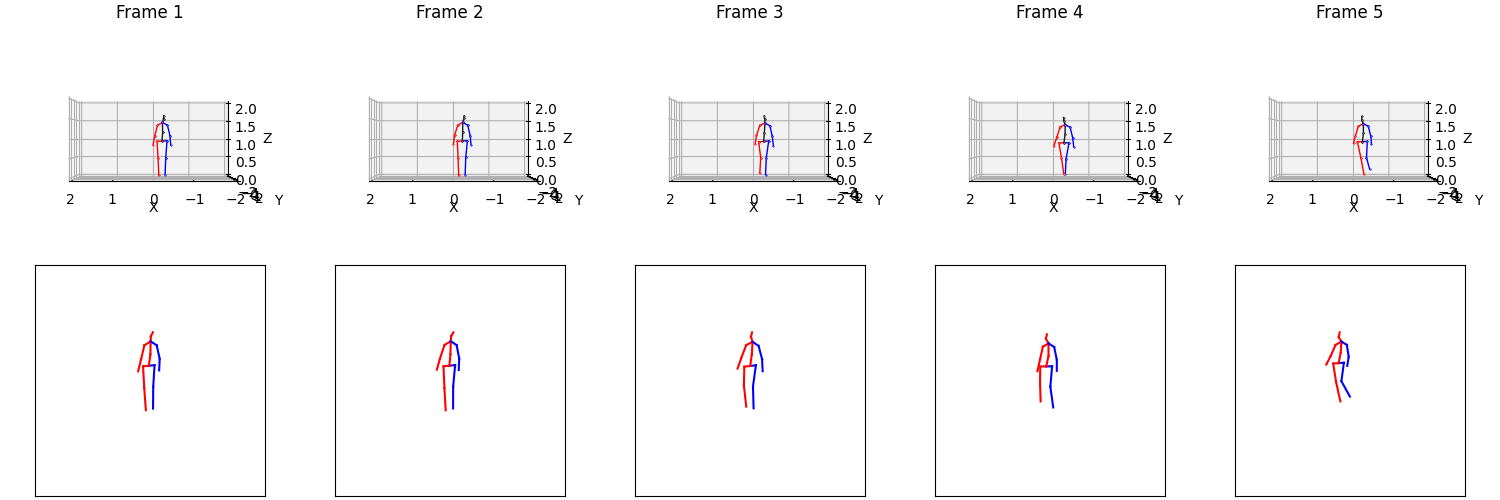

In [9]:
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout(h_pad=-1, w_pad=-1)

%matplotlib widget
fig = plt.figure(0, figsize=(15, 5), layout='constrained')
fig.clear()
axd = fig.subplot_mosaic(
    """
    ABCDE
    FGHIJ
    """,
    per_subplot_kw={('A', 'B', 'C', 'D', 'E'): {'projection': '3d'}}
)

axA = axes_3d(ax=axd['A'], xlim=(-2, 2), ylim=(-2, 2), zlim=(0, 2), view=(0, 90))
axB = axes_3d(ax=axd['B'], xlim=(-2, 2), ylim=(-2, 2), zlim=(0, 2), view=(0, 90))
axC = axes_3d(ax=axd['C'], xlim=(-2, 2), ylim=(-2, 2), zlim=(0, 2), view=(0, 90))
axD = axes_3d(ax=axd['D'], xlim=(-2, 2), ylim=(-2, 2), zlim=(0, 2), view=(0, 90))
axE = axes_3d(ax=axd['E'], xlim=(-2, 2), ylim=(-2, 2), zlim=(0, 2), view=(0, 90))
camera_list_3d = [axA, axB, axC, axD, axE]

axF = axes_2d(ax=axd['F'], H=1000, W=1000, show_axis=False)
axG = axes_2d(ax=axd['G'], H=1000, W=1000, show_axis=False)
axH = axes_2d(ax=axd['H'], H=1000, W=1000, show_axis=False)
axI = axes_2d(ax=axd['I'], H=1000, W=1000, show_axis=False)
axJ = axes_2d(ax=axd['J'], H=1000, W=1000, show_axis=False)
camera_list_2d = [axF, axG, axH, axI, axJ]

axA.set_title('Frame 1')
axB.set_title('Frame 2')
axC.set_title('Frame 3')
axD.set_title('Frame 4')
axE.set_title('Frame 5')

#seq = 10 
start_frame = 0 
for i, ax in enumerate(camera_list_3d): 
    pose_3d = pose_3d_world[::5][start_frame+i*4]
    projected = projection(pose_3d, cam_param['54138969']['proj'])
    draw_3d_pose(ax, pose_3d, dataset='h36m')
    draw_2d_pose(camera_list_2d[i], projected, dataset='h36m')
    
    #draw_3d_pose(camera_list_3d[frame_num], np.array([l_shoulder_trajectory[start_frame+frame_num*10], l_arm_upper_vector_trajectory[start_frame+frame_num*10]]), dataset='vector')
    #print(np.array([l_shoulder_trajectory[start_frame+frame_num], l_arm_upper_vector_trajectory[start_frame+frame_num]]).shape) 
    
plt.show()

In [12]:
# vector to dh model (3d)
batch_l_shoulder = torch.from_numpy(left_upper_arm_vector[:, 0, :]).float().unsqueeze(0) # (B, F, 3)
batch_l_elbow = torch.from_numpy(left_upper_arm_vector[:, 1, :]).float().unsqueeze(0) # (B, F, 3)
batch_left_upper_arm_vector = batch_l_elbow - batch_l_shoulder # (1, F, 3)
batch_azim, batch_elev = calculate_batch_azimuth_elevation(batch_left_upper_arm_vector, degrees=True) # (B, F)
batch_length = torch.norm(batch_left_upper_arm_vector, dim=-1) # (B, F)
gt_data = torch.cat([batch_azim.unsqueeze(-1), batch_elev.unsqueeze(-1), batch_length.unsqueeze(-1)], dim=-1).unsqueeze(2) # (B, F, 3)
gt_data = torch.cat([batch_l_shoulder.unsqueeze(2), gt_data], dim=2) # (B, F, 4)

In [13]:
batch_azim.shape, batch_elev.shape, batch_length.shape, gt_data.shape

(torch.Size([1, 3476]),
 torch.Size([1, 3476]),
 torch.Size([1, 3476]),
 torch.Size([1, 3476, 2, 3]))

In [14]:
# check azim, elev, length
vector_recovered = batch_azim_elev_to_vec(batch_azim, batch_elev, batch_length, batch_l_shoulder, degrees=True)
torch.norm(batch_l_shoulder+batch_left_upper_arm_vector - vector_recovered)

tensor(8.4388e-07)

In [15]:
# vector to dh model (2d)
left_upper_arm_vector_projected.shape
batch_l_shoulder_2d = torch.from_numpy(left_upper_arm_vector_projected[:, 0, :2]).float().unsqueeze(0) # (B, F, 2)
batch_l_elbow_2d = torch.from_numpy(left_upper_arm_vector_projected[:, 1, :2]).float().unsqueeze(0) # (B, F, 2)
batch_left_upper_arm_vector_2d = batch_l_elbow_2d - batch_l_shoulder_2d # (1, F, 2)
batch_theta_2d = torch.atan2(batch_left_upper_arm_vector_2d[:, :, 1], batch_left_upper_arm_vector_2d[:, :, 0]) # (B, F
batch_length_2d = torch.norm(batch_left_upper_arm_vector_2d, dim=-1) # (B, F)
input_data = torch.cat([batch_theta_2d.unsqueeze(-1), batch_length_2d.unsqueeze(-1)], dim=-1).unsqueeze(2) # (B, F, 2)
input_data = torch.cat([batch_l_shoulder_2d.unsqueeze(2), input_data], dim=2) # (B, F, 2, 2)

In [16]:
batch_theta_2d.shape, batch_length_2d.shape, input_data.shape

(torch.Size([1, 3476]), torch.Size([1, 3476]), torch.Size([1, 3476, 2, 2]))

In [17]:
vector_recovered_2d = batch_length_2d.unsqueeze(-1) * torch.cat([torch.cos(batch_theta_2d).unsqueeze(-1), torch.sin(batch_theta_2d).unsqueeze(-1)], dim=-1)
torch.norm(vector_recovered_2d - batch_left_upper_arm_vector_2d)

tensor(5.7015e-07)

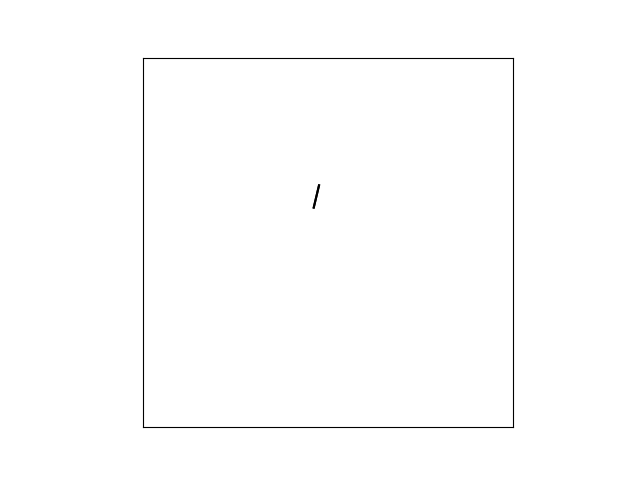

In [18]:
fig = plt.figure(3)
fig.clear()
ax = axes_2d(fig, normalize=True, show_axis=False)
draw_2d_pose(ax, [batch_l_shoulder_2d[0][0], batch_l_shoulder_2d[0][0]+batch_left_upper_arm_vector_2d[0][0]], dataset='vector')
draw_2d_pose(ax, [batch_l_shoulder_2d[0][0], batch_l_shoulder_2d[0][0]+vector_recovered_2d[0][0]], dataset='vector')
plt.show()

In [19]:
import torch
import torch.nn as nn
import math
import warnings
import random
import numpy as np
from collections import OrderedDict
from functools import partial
from itertools import repeat
from lib.model.drop import DropPath

def _no_grad_trunc_normal_(tensor, mean, std, a, b):
    # Cut & paste from PyTorch official master until it's in a few official releases - RW
    # Method based on https://people.sc.fsu.edu/~jburkardt/presentations/truncated_normal.pdf
    def norm_cdf(x):
        # Computes standard normal cumulative distribution function
        return (1. + math.erf(x / math.sqrt(2.))) / 2.

    if (mean < a - 2 * std) or (mean > b + 2 * std):
        warnings.warn("mean is more than 2 std from [a, b] in nn.init.trunc_normal_. "
                      "The distribution of values may be incorrect.",
                      stacklevel=2)

    with torch.no_grad():
        # Values are generated by using a truncated uniform distribution and
        # then using the inverse CDF for the normal distribution.
        # Get upper and lower cdf values
        l = norm_cdf((a - mean) / std)
        u = norm_cdf((b - mean) / std)

        # Uniformly fill tensor with values from [l, u], then translate to
        # [2l-1, 2u-1].
        tensor.uniform_(2 * l - 1, 2 * u - 1)

        # Use inverse cdf transform for normal distribution to get truncated
        # standard normal
        tensor.erfinv_()

        # Transform to proper mean, std
        tensor.mul_(std * math.sqrt(2.))
        tensor.add_(mean)

        # Clamp to ensure it's in the proper range
        tensor.clamp_(min=a, max=b)
        return tensor


def trunc_normal_(tensor, mean=0., std=1., a=-2., b=2.):
    # type: (Tensor, float, float, float, float) -> Tensor
    r"""Fills the input Tensor with values drawn from a truncated
    normal distribution. The values are effectively drawn from the
    normal distribution :math:`\mathcal{N}(\text{mean}, \text{std}^2)`
    with values outside :math:`[a, b]` redrawn until they are within
    the bounds. The method used for generating the random values works
    best when :math:`a \leq \text{mean} \leq b`.
    Args:
        tensor: an n-dimensional `torch.Tensor`
        mean: the mean of the normal distribution
        std: the standard deviation of the normal distribution
        a: the minimum cutoff value
        b: the maximum cutoff value
    Examples:
        >>> w = torch.empty(3, 5)
        >>> nn.init.trunc_normal_(w)
    """
    return _no_grad_trunc_normal_(tensor, mean, std, a, b)

class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features) # 256 -> 256x4
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features) # 256x4 -> 256
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0., st_mode='vanilla'):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads # 256//8 = 32
        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        self.scale = qk_scale or head_dim ** -0.5 # sqrt(32)

        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim) # 256 -> 256
        self.mode = st_mode
        if self.mode == 'parallel':
            self.ts_attn = nn.Linear(dim*2, dim*2)
            self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias) 
        else: # spatial, temporal
            self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias) # 256 -> 256 x 3
        self.proj_drop = nn.Dropout(proj_drop)

        self.attn_count_s = None
        self.attn_count_t = None

    def forward(self, x, seqlen=1): # x=(BxF, 17, 256), seqlen=243
        B, N, C = x.shape # (BxF, 17, 256)
        
        if self.mode == 'series':
            qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
            q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)
            x = self.forward_spatial(q, k, v)
            qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
            q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)
            x = self.forward_temporal(q, k, v, seqlen=seqlen)
        elif self.mode == 'parallel':
            qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
            q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)
            x_t = self.forward_temporal(q, k, v, seqlen=seqlen)
            x_s = self.forward_spatial(q, k, v)
            
            alpha = torch.cat([x_s, x_t], dim=-1)
            alpha = alpha.mean(dim=1, keepdim=True)
            alpha = self.ts_attn(alpha).reshape(B, 1, C, 2)
            alpha = alpha.softmax(dim=-1)
            x = x_t * alpha[:,:,:,1] + x_s * alpha[:,:,:,0]
        elif self.mode == 'coupling':
            qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
            q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)
            x = self.forward_coupling(q, k, v, seqlen=seqlen)
        elif self.mode == 'vanilla':
            qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
            q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)
            x = self.forward_spatial(q, k, v)
        elif self.mode == 'temporal':
            qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4) # x: (BxF, 17, 256) -> output: (BxF, 17, 256x3) -> reshape: (BxF, 17, 3, 8, 32) -> permute: (3, BxF, 8, 17, 32)
            q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple) # q, k, v: (BxF, 8, 17, 32)
            x = self.forward_temporal(q, k, v, seqlen=seqlen)
        elif self.mode == 'spatial':
            qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4) # x: (BxF, 17, 256) -> output: (BxF, 17, 256x3) -> reshape: (BxF, 17, 3, 8, 32) -> permute: (3, BxF, 8, 17, 32)
            q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple) # q, k, v: (BxF, 8, 17, 32)
            x = self.forward_spatial(q, k, v) # (BxF, 17, 256)
        else:
            raise NotImplementedError(self.mode)
        x = self.proj(x) # (BxF, 17, 256) -> (BxF, 17, 256)
        x = self.proj_drop(x)
        return x
    
    def reshape_T(self, x, seqlen=1, inverse=False):
        if not inverse:
            N, C = x.shape[-2:]
            x = x.reshape(-1, seqlen, self.num_heads, N, C).transpose(1,2)
            x = x.reshape(-1, self.num_heads, seqlen*N, C) #(B, H, TN, c)
        else:
            TN, C = x.shape[-2:]
            x = x.reshape(-1, self.num_heads, seqlen, TN // seqlen, C).transpose(1,2)
            x = x.reshape(-1, self.num_heads, TN // seqlen, C) #(BT, H, N, C)
        return x 

    def forward_coupling(self, q, k, v, seqlen=8):
        BT, _, N, C = q.shape
        q = self.reshape_T(q, seqlen)
        k = self.reshape_T(k, seqlen)
        v = self.reshape_T(v, seqlen)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = attn @ v
        x = self.reshape_T(x, seqlen, inverse=True)
        x = x.transpose(1,2).reshape(BT, N, C*self.num_heads)
        return x

    def forward_spatial(self, q, k, v): # q, k, v: (BxF, 8, 17, 32)
        B, _, N, C = q.shape
        # scaled dot-product attention
        attn = (q @ k.transpose(-2, -1)) * self.scale # (BxF, 8, 17, 32) @ (BxF, 8, 32, 17) * (1) = (BxF, 8, 17, 17)
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = attn @ v # BxF, 8, 17, 17) @ (BxF, 8, 17, 32) = (BxF, 8, 17, 32)
        x = x.transpose(1,2).reshape(B, N, C*self.num_heads) # x: (BxF, 8, 17, 32) -> transpose: (BxF, 17, 8, 32) -> reshape: (BxF, 17, 32x8) = (BxF, 17, 256)
        return x
        
    def forward_temporal(self, q, k, v, seqlen=8): # q, k, v: (BxF, 8, 17, 32), seqlen=243
        B, _, N, C = q.shape
        qt = q.reshape(-1, seqlen, self.num_heads, N, C).permute(0, 2, 3, 1, 4) # (BxF, 8, 17, 32) -> reshape: (B, 243, 8, 17, 32) -> permute: (B, 8, 17, 243, 32) # (B, H, N, T, C) 
        kt = k.reshape(-1, seqlen, self.num_heads, N, C).permute(0, 2, 3, 1, 4) # (BxF, 8, 17, 32) -> reshape: (B, 243, 8, 17, 32) -> permute: (B, 8, 17, 243, 32) # (B, H, N, T, C)
        vt = v.reshape(-1, seqlen, self.num_heads, N, C).permute(0, 2, 3, 1, 4) # (BxF, 8, 17, 32) -> reshape: (B, 243, 8, 17, 32) -> permute: (B, 8, 17, 243, 32) # (B, H, N, T, C)

        attn = (qt @ kt.transpose(-2, -1)) * self.scale # (B, 8, 17, 243, 32) @ (B, 8, 17, 32, 243) * (1) = (B, 8, 17, 243, 243)
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = attn @ vt # (B, 8, 17, 243, 243) @ (B, 8, 17, 243, 32) = (B, 8, 17, 243, 32) # (B, H, N, T, C)
        x = x.permute(0, 3, 2, 1, 4).reshape(B, N, C*self.num_heads) # x:(B, 8, 17, 243, 32) -> permute: (B, 243, 17, 8, 32) -> reshape: (BxF, 17, 256)
        return x

    def count_attn(self, attn):
        attn = attn.detach().cpu().numpy()
        attn = attn.mean(axis=1)
        attn_t = attn[:, :, 1].mean(axis=1)
        attn_s = attn[:, :, 0].mean(axis=1)
        if self.attn_count_s is None:
            self.attn_count_s = attn_s
            self.attn_count_t = attn_t
        else:
            self.attn_count_s = np.concatenate([self.attn_count_s, attn_s], axis=0)
            self.attn_count_t = np.concatenate([self.attn_count_t, attn_t], axis=0)

class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., mlp_out_ratio=1., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, att_fuse=False):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.norm2 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity() 
        # DropPath: 확률적으로 skip connection(x+f(x)에서 f(x))만 남기는 regularization 방법 
        # nn.Identity(): 입력값을 그대로 출력하는 layer
        mlp_hidden_dim = int(dim * mlp_ratio) # 256 x 4
        mlp_out_dim = int(dim * mlp_out_ratio) # 256
        self.mlp = MLP(in_features=dim, hidden_features=mlp_hidden_dim, out_features=mlp_out_dim, act_layer=act_layer, drop=drop)
    def forward(self, x, seqlen=1): # x=(BxF, 17, 256), seqlen=243
        x = x + self.drop_path(self.attn(self.norm1(x), seqlen)) # (BxF, 17, 256)
        x = x + self.drop_path(self.mlp(self.norm2(x))) # (BxF, 17, 256)
        return x

class DHformer(nn.Module):
    def __init__(self, dim_in=2, dim_out=3, dim_feat=256, dim_rep=256,
                 depth=5, num_heads=8, mlp_ratio=4, 
                 num_joints=2, maxlen=243, 
                 qkv_bias=True, qk_scale=None, drop_rate=0., attn_drop_rate=0., drop_path_rate=0., norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim_out = dim_out
        self.dim_feat = dim_feat
        self.joints_embed = nn.Linear(dim_in, dim_feat) # FC layer before DSTformer - (BxF, 17, 3) -> (BxF, 17, 256)
        self.pos_drop = nn.Dropout(p=drop_rate) 
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        # attention block
        self.blocks = nn.ModuleList([
            Block(
                dim=dim_feat, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(dim_feat)
        if dim_rep:
            self.pre_logits = nn.Sequential(OrderedDict([ # final pre-FC layer
                ('fc', nn.Linear(dim_feat, dim_rep)),
                ('act', nn.Tanh())
            ]))
        else:
            self.pre_logits = nn.Identity()
        self.head = nn.Linear(dim_rep, dim_out) if dim_out > 0 else nn.Identity() # final FC layer 
        self.temp_embed = nn.Parameter(torch.zeros(1, maxlen, 1, dim_feat)) # learnable temporal positional encoding - (1, 243, 1, 256)
        self.pos_embed = nn.Parameter(torch.zeros(1, num_joints, dim_feat)) # learnable spatial positional encoding - (1, 17, 256)
        trunc_normal_(self.temp_embed, std=.02)
        trunc_normal_(self.pos_embed, std=.02)
        self.apply(self._init_weights) # 해당 Module의 모든 sub-module에 인수받은 함수를 적용시켜준다.

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def get_classifier(self):
        return self.head

    def reset_classifier(self, dim_out, global_pool=''):
        self.dim_out = dim_out
        self.head = nn.Linear(self.dim_feat, dim_out) if dim_out > 0 else nn.Identity()

    def forward(self, x, return_rep=False):   
        B, F, J, C = x.shape # Batch, Frame, Joint, Channel
        x = x.reshape(-1, J, C) # Batch*Frame, Joint, Channel
        BF = x.shape[0]
        x = self.joints_embed(x) # feature embedding - (BxF, J, 3) -> (BxF, J, dim_feat)
        x = x + self.pos_embed # add learnable spatial positional encoding - (BxF, J, dim_feat) + (1, J, dim_feat)
        _, J, C = x.shape # J=17, C=dim_feat
        x = x.reshape(-1, F, J, C) + self.temp_embed[:,:F,:,:] # add learnable temporal positional encoding
        x = x.reshape(BF, J, C) # (BxF, J, dim_feat)
        x = self.pos_drop(x)
        #alphas = []
        for idx, blk in enumerate(self.blocks):
            x = blk(x, F) # Block의 forward 함수 -> x: (BxF, J, dim_feat), F=243, x: (BxF, J, dim_feat)
        x = self.norm(x) # layer normalization
        x = x.reshape(B, F, J, -1) # # (B, F, J, dim_feat)
        x = self.pre_logits(x)  # (B, F, J, dim_feat) ->  (B, F, J, dim_rep)   motion representation E or pass
        if return_rep:
            return x
        x = self.head(x) # 3D motion X_hat # (B, J, 17, dim_rep) -> (B, F, J, dim_out)
        return x

    def get_representation(self, x):
        return self.forward(x, return_rep=True)

In [20]:
dhformer = DHformer()
dhformer = dhformer.cuda()
dhformer = dhformer.eval()

In [26]:
test_input = torch.rand(8, 243, 2, 2).cuda()
test_input.shape

torch.Size([8, 243, 2, 2])

In [31]:
test_output = dhformer(input_data[:, :243].cuda())
test_output.shape

torch.Size([1, 243, 2, 3])

In [36]:
torch.norm(test_output - gt_data[:, :243].cuda())

tensor(1745.7692, device='cuda:0', grad_fn=<CopyBackwards>)

In [23]:
batch_input_list = []
batch_gt_list = []
for start_frame in range(0, len(input_data[0]), 50):
    temp_input = input_data[:, start_frame:start_frame+243, :].clone()
    temp_gt = gt_data[:, start_frame:start_frame+243, :].clone()
    print(temp_input.shape, temp_gt.shape)
    if temp_input.shape[1] == 243:
        batch_input_list.append(temp_input)
        batch_gt_list.append(temp_gt)
        #print(temp.shape)

torch.Size([1, 243, 2, 2]) torch.Size([1, 243, 2, 3])
torch.Size([1, 243, 2, 2]) torch.Size([1, 243, 2, 3])
torch.Size([1, 243, 2, 2]) torch.Size([1, 243, 2, 3])
torch.Size([1, 243, 2, 2]) torch.Size([1, 243, 2, 3])
torch.Size([1, 243, 2, 2]) torch.Size([1, 243, 2, 3])
torch.Size([1, 243, 2, 2]) torch.Size([1, 243, 2, 3])
torch.Size([1, 243, 2, 2]) torch.Size([1, 243, 2, 3])
torch.Size([1, 243, 2, 2]) torch.Size([1, 243, 2, 3])
torch.Size([1, 243, 2, 2]) torch.Size([1, 243, 2, 3])
torch.Size([1, 243, 2, 2]) torch.Size([1, 243, 2, 3])
torch.Size([1, 243, 2, 2]) torch.Size([1, 243, 2, 3])
torch.Size([1, 243, 2, 2]) torch.Size([1, 243, 2, 3])
torch.Size([1, 243, 2, 2]) torch.Size([1, 243, 2, 3])
torch.Size([1, 243, 2, 2]) torch.Size([1, 243, 2, 3])
torch.Size([1, 243, 2, 2]) torch.Size([1, 243, 2, 3])
torch.Size([1, 243, 2, 2]) torch.Size([1, 243, 2, 3])
torch.Size([1, 243, 2, 2]) torch.Size([1, 243, 2, 3])
torch.Size([1, 243, 2, 2]) torch.Size([1, 243, 2, 3])
torch.Size([1, 243, 2, 2]) t

In [24]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [168]:
import torch.optim as optim

dhformer = dhformer.train()
mseloss = nn.MSELoss()
lr = 0.005
weight_decay = 0.01
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, dhformer.parameters()), lr=lr, weight_decay=weight_decay)

losses = {}
losses['loss'] = AverageMeter()

num_epoch = 500
idxs = [x for x in range(len(batch_input_list))]
for epoch in range(num_epoch):
    random.shuffle(idxs)
    optimizer.zero_grad()
    for idx in tqdm(idxs):
        batch_input = batch_input_list[idx]
        pred = dhformer(batch_input[:, :243, :].cuda())
        loss = mseloss(pred, batch_gt_list[idx].cuda())
        losses['loss'].update(loss.item(), batch_input.size(0))
        loss.backward()
        optimizer.step()
    print(losses['loss'].avg)

100%|██████████| 65/65 [00:00<00:00, 94.91it/s]


2638.6401254507214


100%|██████████| 65/65 [00:00<00:00, 95.13it/s]


2804.260735144982


100%|██████████| 65/65 [00:00<00:00, 98.92it/s] 


2994.517462940705


100%|██████████| 65/65 [00:00<00:00, 105.07it/s]


3083.852877338116


100%|██████████| 65/65 [00:00<00:00, 105.01it/s]


3187.4278694035456


100%|██████████| 65/65 [00:00<00:00, 105.12it/s]


3256.008312205779


100%|██████████| 65/65 [00:00<00:00, 104.94it/s]


3304.734537715702


100%|██████████| 65/65 [00:00<00:00, 95.19it/s]


3344.6549393873947


100%|██████████| 65/65 [00:00<00:00, 95.13it/s]


3298.6859300923143


100%|██████████| 65/65 [00:00<00:00, 94.40it/s]


3210.561608323317


100%|██████████| 65/65 [00:00<00:00, 95.59it/s]


3132.73704714475


100%|██████████| 65/65 [00:00<00:00, 98.87it/s] 


3063.988739404923


100%|██████████| 65/65 [00:00<00:00, 103.75it/s]


3006.5725379356973


100%|██████████| 65/65 [00:00<00:00, 103.99it/s]


2961.1436180030905


100%|██████████| 65/65 [00:00<00:00, 103.57it/s]


2927.43912891877


100%|██████████| 65/65 [00:00<00:00, 103.77it/s]


2900.3232794541577


100%|██████████| 65/65 [00:00<00:00, 103.87it/s]


2876.3094039986036


100%|██████████| 65/65 [00:00<00:00, 104.74it/s]


2860.205758327908


100%|██████████| 65/65 [00:00<00:00, 104.18it/s]


2848.224669520575


100%|██████████| 65/65 [00:00<00:00, 104.19it/s]


2840.2001963923526


100%|██████████| 65/65 [00:00<00:00, 104.31it/s]


2840.626458270733


100%|██████████| 65/65 [00:00<00:00, 103.79it/s]


2847.2984732247733


100%|██████████| 65/65 [00:00<00:00, 104.06it/s]


2857.9945264733356


100%|██████████| 65/65 [00:00<00:00, 103.87it/s]


2863.47598822178


100%|██████████| 65/65 [00:00<00:00, 103.83it/s]


2858.065624774639


100%|██████████| 65/65 [00:00<00:00, 103.90it/s]


2845.2180404031064


100%|██████████| 65/65 [00:00<00:00, 103.75it/s]


2829.915129937066


100%|██████████| 65/65 [00:00<00:00, 104.01it/s]


2813.2564411875965


100%|██████████| 65/65 [00:00<00:00, 104.00it/s]


2800.6752315774206


100%|██████████| 65/65 [00:00<00:00, 103.74it/s]


2796.262518811348


100%|██████████| 65/65 [00:00<00:00, 103.94it/s]


2806.8675691590415


100%|██████████| 65/65 [00:00<00:00, 103.97it/s]


2832.962157058716


100%|██████████| 65/65 [00:00<00:00, 103.74it/s]


2865.7454065994225


100%|██████████| 65/65 [00:00<00:00, 103.95it/s]


2883.097787378924


100%|██████████| 65/65 [00:00<00:00, 103.76it/s]


2886.254343476348


100%|██████████| 65/65 [00:00<00:00, 104.12it/s]


2884.1166490603714


100%|██████████| 65/65 [00:00<00:00, 103.90it/s]


2880.0300917278455


100%|██████████| 65/65 [00:00<00:00, 103.95it/s]


2873.9181983360877


100%|██████████| 65/65 [00:00<00:00, 103.99it/s]


2866.511607273561


100%|██████████| 65/65 [00:00<00:00, 103.47it/s]


2856.3670356867865


100%|██████████| 65/65 [00:00<00:00, 103.85it/s]


2846.562311672762


100%|██████████| 65/65 [00:00<00:00, 104.15it/s]


2837.1013532366073


100%|██████████| 65/65 [00:00<00:00, 97.17it/s] 


2831.226918796819


100%|██████████| 65/65 [00:00<00:00, 94.43it/s]


2829.514172598032


100%|██████████| 65/65 [00:00<00:00, 94.40it/s]


2831.993240998097


100%|██████████| 65/65 [00:00<00:00, 95.14it/s]


2836.019403361955


100%|██████████| 65/65 [00:00<00:00, 95.51it/s]


2836.7402010104465


100%|██████████| 65/65 [00:00<00:00, 96.42it/s]


2833.053466738187


100%|██████████| 65/65 [00:00<00:00, 95.86it/s]


2825.8599283598655


100%|██████████| 65/65 [00:00<00:00, 95.12it/s]


2817.818641845703


100%|██████████| 65/65 [00:00<00:00, 94.81it/s]


2808.453057189297


100%|██████████| 65/65 [00:00<00:00, 95.19it/s]


2800.257866781562


100%|██████████| 65/65 [00:00<00:00, 94.83it/s]


2792.8922715495737


100%|██████████| 65/65 [00:00<00:00, 94.99it/s]


2787.9794624872015


100%|██████████| 65/65 [00:00<00:00, 95.04it/s]


2784.580593534883


100%|██████████| 65/65 [00:00<00:00, 97.92it/s]


2781.699180955153


100%|██████████| 65/65 [00:00<00:00, 104.42it/s]


2779.791357899613


100%|██████████| 65/65 [00:00<00:00, 106.11it/s]


2778.6515917385923


100%|██████████| 65/65 [00:00<00:00, 106.59it/s]


2779.9564520924155


100%|██████████| 65/65 [00:00<00:00, 106.44it/s]


2785.7207609518982


100%|██████████| 65/65 [00:00<00:00, 106.28it/s]


2797.2352051858793


100%|██████████| 65/65 [00:00<00:00, 106.34it/s]


2813.3174756525764


100%|██████████| 65/65 [00:00<00:00, 106.86it/s]


2825.1704383710367


100%|██████████| 65/65 [00:00<00:00, 106.54it/s]


2827.821925133925


100%|██████████| 65/65 [00:00<00:00, 106.55it/s]


2824.8630285716763


100%|██████████| 65/65 [00:00<00:00, 106.73it/s]


2821.3914382472185


100%|██████████| 65/65 [00:00<00:00, 106.53it/s]


2819.847620371699


100%|██████████| 65/65 [00:00<00:00, 106.12it/s]


2820.2806131768552


100%|██████████| 65/65 [00:00<00:00, 106.40it/s]


2821.77417008518


100%|██████████| 65/65 [00:00<00:00, 106.39it/s]


2822.3022095665565


100%|██████████| 65/65 [00:00<00:00, 106.77it/s]


2820.344054765794


100%|██████████| 65/65 [00:00<00:00, 106.55it/s]


2815.84888811682


100%|██████████| 65/65 [00:00<00:00, 106.77it/s]


2810.492508342972


100%|██████████| 65/65 [00:00<00:00, 106.37it/s]


2803.9878957514456


100%|██████████| 65/65 [00:00<00:00, 106.38it/s]


2798.020096078726


100%|██████████| 65/65 [00:00<00:00, 106.60it/s]


2792.6975216019973


100%|██████████| 65/65 [00:00<00:00, 106.62it/s]


2788.6079250217554


100%|██████████| 65/65 [00:00<00:00, 106.54it/s]


2788.204989786543


100%|██████████| 65/65 [00:00<00:00, 105.29it/s]


2789.790500374175


100%|██████████| 65/65 [00:00<00:00, 106.55it/s]


2793.470208270733


100%|██████████| 65/65 [00:00<00:00, 106.36it/s]


2794.787540840808


100%|██████████| 65/65 [00:00<00:00, 106.18it/s]


2793.1727106205294


100%|██████████| 65/65 [00:00<00:00, 106.70it/s]


2789.833428689216


100%|██████████| 65/65 [00:00<00:00, 106.84it/s]


2785.2150596646597


100%|██████████| 65/65 [00:00<00:00, 105.69it/s]


2780.155332307427


100%|██████████| 65/65 [00:00<00:00, 106.17it/s]


2775.4995492679277


100%|██████████| 65/65 [00:00<00:00, 106.77it/s]


2772.0091558454733


100%|██████████| 65/65 [00:00<00:00, 106.84it/s]


2770.870855435458


100%|██████████| 65/65 [00:00<00:00, 106.67it/s]


2774.1573204521897


100%|██████████| 65/65 [00:00<00:00, 106.74it/s]


2783.5439581350993


100%|██████████| 65/65 [00:00<00:00, 106.76it/s]


2797.4294049428263


100%|██████████| 65/65 [00:00<00:00, 106.40it/s]


2810.295533073706


100%|██████████| 65/65 [00:00<00:00, 106.93it/s]


2816.9960495361124


100%|██████████| 65/65 [00:00<00:00, 106.77it/s]


2817.698932484129


100%|██████████| 65/65 [00:00<00:00, 104.86it/s]


2815.0641563508193


100%|██████████| 65/65 [00:00<00:00, 106.00it/s]


2810.64706985278


100%|██████████| 65/65 [00:00<00:00, 106.82it/s]


2805.6477055718274


100%|██████████| 65/65 [00:00<00:00, 106.78it/s]


2800.454818356692


100%|██████████| 65/65 [00:00<00:00, 107.07it/s]


2795.776106789803


100%|██████████| 65/65 [00:00<00:00, 106.89it/s]


2790.972844041091


100%|██████████| 65/65 [00:00<00:00, 106.47it/s]


2786.3019808209224


100%|██████████| 65/65 [00:00<00:00, 106.80it/s]


2782.6979098358843


100%|██████████| 65/65 [00:00<00:00, 105.03it/s]


2781.9226499413626


100%|██████████| 65/65 [00:00<00:00, 104.92it/s]


2782.228043514455


100%|██████████| 65/65 [00:00<00:00, 104.31it/s]


2784.265793457031


100%|██████████| 65/65 [00:00<00:00, 104.65it/s]


2786.556426408433


100%|██████████| 65/65 [00:00<00:00, 104.40it/s]


2786.3713733445475


100%|██████████| 65/65 [00:00<00:00, 104.18it/s]


2784.811972689289


100%|██████████| 65/65 [00:00<00:00, 104.54it/s]


2782.0243396659425


100%|██████████| 65/65 [00:00<00:00, 104.62it/s]


2779.0321145651224


100%|██████████| 65/65 [00:00<00:00, 104.10it/s]


2776.8595247074372


100%|██████████| 65/65 [00:00<00:00, 103.04it/s]


2775.3868971939924


100%|██████████| 65/65 [00:00<00:00, 102.95it/s]


2774.873771768236


100%|██████████| 65/65 [00:00<00:00, 102.90it/s]


2775.4875906137318


100%|██████████| 65/65 [00:00<00:00, 103.40it/s]


2776.4527153010035


100%|██████████| 65/65 [00:00<00:00, 103.08it/s]


2777.81679500509


100%|██████████| 65/65 [00:00<00:00, 103.47it/s]


2780.109352937456


100%|██████████| 65/65 [00:00<00:00, 104.57it/s]


2784.459207300537


100%|██████████| 65/65 [00:00<00:00, 104.91it/s]


2790.494617961743


100%|██████████| 65/65 [00:00<00:00, 104.17it/s]


2795.2885548987756


100%|██████████| 65/65 [00:00<00:00, 104.78it/s]


2796.3816494252374


100%|██████████| 65/65 [00:00<00:00, 104.81it/s]


2794.2018719474727


100%|██████████| 65/65 [00:00<00:00, 105.05it/s]


2790.5376566225473


100%|██████████| 65/65 [00:00<00:00, 105.00it/s]


2786.2772484488287


100%|██████████| 65/65 [00:00<00:00, 113.29it/s]


2781.922388619291


100%|██████████| 65/65 [00:00<00:00, 115.56it/s]


2777.5419238415393


100%|██████████| 65/65 [00:00<00:00, 115.54it/s]


2773.2300704355316


100%|██████████| 65/65 [00:00<00:00, 115.36it/s]


2769.0362335938676


100%|██████████| 65/65 [00:00<00:00, 115.44it/s]


2765.001487823832


100%|██████████| 65/65 [00:00<00:00, 115.52it/s]


2761.3246273316154


100%|██████████| 65/65 [00:00<00:00, 115.47it/s]


2757.7378904888087


100%|██████████| 65/65 [00:00<00:00, 115.60it/s]


2754.620207530913


100%|██████████| 65/65 [00:00<00:00, 115.52it/s]


2753.2408871087537


100%|██████████| 65/65 [00:00<00:00, 115.34it/s]


2753.5933404407874


100%|██████████| 65/65 [00:00<00:00, 105.19it/s]


2757.6410876290956


100%|██████████| 65/65 [00:00<00:00, 104.10it/s]


2768.603609566667


100%|██████████| 65/65 [00:00<00:00, 104.00it/s]


2782.8035567080688


100%|██████████| 65/65 [00:00<00:00, 103.54it/s]


2793.25023122594


100%|██████████| 65/65 [00:00<00:00, 104.19it/s]


2795.9702932740947


100%|██████████| 65/65 [00:00<00:00, 104.43it/s]


2794.9301991087527


100%|██████████| 65/65 [00:00<00:00, 104.05it/s]


2792.7021225849658


100%|██████████| 65/65 [00:00<00:00, 104.36it/s]


2790.1498951226895


100%|██████████| 65/65 [00:00<00:00, 104.47it/s]


2788.210485334227


100%|██████████| 65/65 [00:00<00:00, 104.57it/s]


2787.728110478067


100%|██████████| 65/65 [00:00<00:00, 114.83it/s]


2789.417838487701


100%|██████████| 65/65 [00:00<00:00, 115.85it/s]


2792.853854829971


100%|██████████| 65/65 [00:00<00:00, 115.80it/s]


2795.9250380519547


100%|██████████| 65/65 [00:00<00:00, 115.71it/s]


2796.579365777474


100%|██████████| 65/65 [00:00<00:00, 115.69it/s]


2794.935413587075


100%|██████████| 65/65 [00:00<00:00, 115.62it/s]


2792.133773800581


100%|██████████| 65/65 [00:00<00:00, 115.68it/s]


2788.9998570788593


100%|██████████| 65/65 [00:00<00:00, 109.28it/s]


2785.644167343325


100%|██████████| 65/65 [00:00<00:00, 104.61it/s]


2782.503048363902


100%|██████████| 65/65 [00:00<00:00, 103.35it/s]


2779.598125360967


100%|██████████| 65/65 [00:00<00:00, 103.77it/s]


2777.1101373003257


100%|██████████| 65/65 [00:00<00:00, 103.74it/s]


2775.227717316456


100%|██████████| 65/65 [00:00<00:00, 103.62it/s]


2774.1753082081013


100%|██████████| 65/65 [00:00<00:00, 104.09it/s]


2774.036702055964


100%|██████████| 65/65 [00:00<00:00, 103.09it/s]


2775.1940654221285


100%|██████████| 65/65 [00:00<00:00, 103.55it/s]


2777.0973498593844


100%|██████████| 65/65 [00:00<00:00, 104.13it/s]


2779.6277823632718


100%|██████████| 65/65 [00:00<00:00, 103.37it/s]


2782.8395150817696


100%|██████████| 65/65 [00:00<00:00, 102.95it/s]


2785.5125751374744


100%|██████████| 65/65 [00:00<00:00, 103.16it/s]


2787.320646384062


100%|██████████| 65/65 [00:00<00:00, 104.99it/s]


2787.074508361105


100%|██████████| 65/65 [00:00<00:00, 104.29it/s]


2785.5480992724656


100%|██████████| 65/65 [00:00<00:00, 103.89it/s]


2783.400480229445


100%|██████████| 65/65 [00:00<00:00, 105.14it/s]


2781.144206461365


100%|██████████| 65/65 [00:00<00:00, 105.13it/s]


2779.376408609174


100%|██████████| 65/65 [00:00<00:00, 104.95it/s]


2778.714419061307


100%|██████████| 65/65 [00:00<00:00, 105.00it/s]


2779.7259710383105


100%|██████████| 65/65 [00:00<00:00, 105.09it/s]


2782.188438571118


100%|██████████| 65/65 [00:00<00:00, 105.11it/s]


2784.980758331828


100%|██████████| 65/65 [00:00<00:00, 104.79it/s]


2786.35296562323


100%|██████████| 65/65 [00:00<00:00, 104.92it/s]


2785.899091362251


100%|██████████| 65/65 [00:00<00:00, 104.89it/s]


2784.496376955259


100%|██████████| 65/65 [00:00<00:00, 105.02it/s]


2782.825823547549


100%|██████████| 65/65 [00:00<00:00, 104.84it/s]


2781.3874800171848


100%|██████████| 65/65 [00:00<00:00, 104.98it/s]


2780.460018788441


100%|██████████| 65/65 [00:00<00:00, 104.96it/s]


2780.3190842431222


100%|██████████| 65/65 [00:00<00:00, 104.86it/s]


2780.45070641514


100%|██████████| 65/65 [00:00<00:00, 104.84it/s]


2780.867684908147


100%|██████████| 65/65 [00:00<00:00, 104.76it/s]


2780.934857524088


100%|██████████| 65/65 [00:00<00:00, 104.30it/s]


2780.930128448384


100%|██████████| 65/65 [00:00<00:00, 104.43it/s]


2780.7764459926425


100%|██████████| 65/65 [00:00<00:00, 104.14it/s]


2780.730300254601


100%|██████████| 65/65 [00:00<00:00, 104.40it/s]


2781.075900638883


100%|██████████| 65/65 [00:00<00:00, 104.40it/s]


2781.297566335525


100%|██████████| 65/65 [00:00<00:00, 104.29it/s]


2781.1538185104105


100%|██████████| 65/65 [00:00<00:00, 104.24it/s]


2780.349024475345


100%|██████████| 65/65 [00:00<00:00, 104.84it/s]


2778.7801102084013


100%|██████████| 65/65 [00:00<00:00, 104.41it/s]


2776.9057544757156


100%|██████████| 65/65 [00:00<00:00, 104.99it/s]


2774.8725958619284


100%|██████████| 65/65 [00:00<00:00, 104.81it/s]


2773.042031223863


100%|██████████| 65/65 [00:00<00:00, 104.55it/s]


2771.923264473157


100%|██████████| 65/65 [00:00<00:00, 104.65it/s]


2771.9649603923035


100%|██████████| 65/65 [00:00<00:00, 103.95it/s]


2773.4325312711635


100%|██████████| 65/65 [00:00<00:00, 104.43it/s]


2775.8118551329853


100%|██████████| 65/65 [00:00<00:00, 104.08it/s]


2777.8983791166997


100%|██████████| 65/65 [00:00<00:00, 104.59it/s]


2778.9344682100736


100%|██████████| 65/65 [00:00<00:00, 104.23it/s]


2779.214177450712


100%|██████████| 65/65 [00:00<00:00, 104.24it/s]


2779.323718350041


100%|██████████| 65/65 [00:00<00:00, 104.32it/s]


2779.4050527164277


100%|██████████| 65/65 [00:00<00:00, 103.91it/s]


2779.3969947320124


100%|██████████| 65/65 [00:00<00:00, 103.70it/s]


2778.836237508978


100%|██████████| 65/65 [00:00<00:00, 103.67it/s]


2777.809258472537


100%|██████████| 65/65 [00:00<00:00, 104.72it/s]


2776.392553706401


100%|██████████| 65/65 [00:00<00:00, 104.80it/s]


2774.880835195688


100%|██████████| 65/65 [00:00<00:00, 104.62it/s]


2774.1239066867033


100%|██████████| 65/65 [00:00<00:00, 104.81it/s]


2774.569586999914


100%|██████████| 65/65 [00:00<00:00, 104.63it/s]


2775.8896353359687


100%|██████████| 65/65 [00:00<00:00, 105.11it/s]


2777.2657526954686


100%|██████████| 65/65 [00:00<00:00, 104.66it/s]


2778.1162069963348


100%|██████████| 65/65 [00:00<00:00, 104.74it/s]


2777.7904174892446


100%|██████████| 65/65 [00:00<00:00, 104.88it/s]


2776.639226991384


100%|██████████| 65/65 [00:00<00:00, 104.80it/s]


2774.860995013897


100%|██████████| 65/65 [00:00<00:00, 104.76it/s]


2772.966771067579


100%|██████████| 65/65 [00:00<00:00, 104.86it/s]


2771.147545111743


100%|██████████| 65/65 [00:00<00:00, 104.91it/s]


2769.8467077332293


100%|██████████| 65/65 [00:00<00:00, 104.76it/s]


2769.3017038369344


100%|██████████| 65/65 [00:00<00:00, 104.76it/s]


2769.9665545486464


100%|██████████| 65/65 [00:00<00:00, 104.61it/s]


2771.9975220784


100%|██████████| 65/65 [00:00<00:00, 104.94it/s]


2774.940540056074


100%|██████████| 65/65 [00:00<00:00, 104.67it/s]


2777.7322568201757


100%|██████████| 65/65 [00:00<00:00, 104.53it/s]


2779.622005425347


100%|██████████| 65/65 [00:00<00:00, 104.99it/s]


2780.436834650319


100%|██████████| 65/65 [00:00<00:00, 104.49it/s]


2780.2476997750364


100%|██████████| 65/65 [00:00<00:00, 104.76it/s]


2779.3240187342512


100%|██████████| 65/65 [00:00<00:00, 104.34it/s]


2777.864896990206


100%|██████████| 65/65 [00:00<00:00, 104.51it/s]


2776.217780578001


100%|██████████| 65/65 [00:00<00:00, 104.64it/s]


2774.6314753890315


100%|██████████| 65/65 [00:00<00:00, 104.25it/s]


2773.1450675377478


100%|██████████| 65/65 [00:00<00:00, 104.96it/s]


2772.5165706237813


100%|██████████| 65/65 [00:00<00:00, 103.64it/s]


2772.4374682745597


100%|██████████| 65/65 [00:00<00:00, 103.78it/s]


2772.977993691502


100%|██████████| 65/65 [00:00<00:00, 103.72it/s]


2773.8768299883627


100%|██████████| 65/65 [00:00<00:00, 103.17it/s]


2774.5883785219326


100%|██████████| 65/65 [00:00<00:00, 103.44it/s]


2774.6249856466775


100%|██████████| 65/65 [00:00<00:00, 103.13it/s]


2773.74711617432


100%|██████████| 65/65 [00:00<00:00, 103.34it/s]


2772.396793177678


100%|██████████| 65/65 [00:00<00:00, 103.92it/s]


2770.903594263529


100%|██████████| 65/65 [00:00<00:00, 104.60it/s]


2769.6774829202445


100%|██████████| 65/65 [00:00<00:00, 104.20it/s]


2768.8490642435304


100%|██████████| 65/65 [00:00<00:00, 104.50it/s]


2768.8448990310726


100%|██████████| 65/65 [00:00<00:00, 104.15it/s]


2769.8897290269024


100%|██████████| 65/65 [00:00<00:00, 104.42it/s]


2772.1207740540353


100%|██████████| 65/65 [00:00<00:00, 104.25it/s]


2774.9868217627454


100%|██████████| 65/65 [00:00<00:00, 104.24it/s]


2777.5498566506812


100%|██████████| 65/65 [00:00<00:00, 103.74it/s]


2778.8629917619696


100%|██████████| 65/65 [00:00<00:00, 104.46it/s]


2778.835528147536


100%|██████████| 65/65 [00:00<00:00, 104.37it/s]


2777.5081194228496


100%|██████████| 65/65 [00:00<00:00, 104.09it/s]


2775.5132827293014


100%|██████████| 65/65 [00:00<00:00, 104.30it/s]


2773.5175345226276


100%|██████████| 65/65 [00:00<00:00, 104.34it/s]


2771.4574172206535


100%|██████████| 65/65 [00:00<00:00, 104.36it/s]


2769.3748590980863


100%|██████████| 65/65 [00:00<00:00, 104.00it/s]


2767.304353097769


100%|██████████| 65/65 [00:00<00:00, 104.23it/s]


2765.273546164866


100%|██████████| 65/65 [00:00<00:00, 103.64it/s]


2763.304076274947


100%|██████████| 65/65 [00:00<00:00, 104.55it/s]


2761.362557917233


100%|██████████| 65/65 [00:00<00:00, 104.24it/s]


2759.770862195619


100%|██████████| 65/65 [00:00<00:00, 104.34it/s]


2758.4593121659886


100%|██████████| 65/65 [00:00<00:00, 104.31it/s]


2757.617561179949


100%|██████████| 65/65 [00:00<00:00, 104.35it/s]


2758.301041464347


100%|██████████| 65/65 [00:00<00:00, 104.26it/s]


2761.2055275159005


100%|██████████| 65/65 [00:00<00:00, 104.50it/s]


2766.3819125919867


100%|██████████| 65/65 [00:00<00:00, 104.16it/s]


2770.724181535852


100%|██████████| 65/65 [00:00<00:00, 104.10it/s]


2773.6910946383596


100%|██████████| 65/65 [00:00<00:00, 104.08it/s]


2775.440957455903


100%|██████████| 65/65 [00:00<00:00, 104.06it/s]


2777.050221353236


100%|██████████| 65/65 [00:00<00:00, 104.50it/s]


2779.0359296506354


100%|██████████| 65/65 [00:00<00:00, 104.09it/s]


2781.1160245888345


100%|██████████| 65/65 [00:00<00:00, 104.27it/s]


2782.3366331247184


100%|██████████| 65/65 [00:00<00:00, 103.78it/s]


2782.3672525938478


100%|██████████| 65/65 [00:00<00:00, 103.97it/s]


2781.435380781239


100%|██████████| 65/65 [00:00<00:00, 104.17it/s]


2779.956228061489


100%|██████████| 65/65 [00:00<00:00, 103.95it/s]


2778.2189904560614


100%|██████████| 65/65 [00:00<00:00, 104.24it/s]


2776.3791367191566


100%|██████████| 65/65 [00:00<00:00, 104.36it/s]


2774.5366793051435


100%|██████████| 65/65 [00:00<00:00, 104.69it/s]


2772.7396707076755


100%|██████████| 65/65 [00:00<00:00, 104.52it/s]


2770.9276244412936


100%|██████████| 65/65 [00:00<00:00, 104.40it/s]


2769.17789250501


100%|██████████| 65/65 [00:00<00:00, 104.26it/s]


2767.4732260979267


100%|██████████| 65/65 [00:00<00:00, 104.31it/s]


2765.8751028489664


100%|██████████| 65/65 [00:00<00:00, 104.51it/s]


2764.465666058211


100%|██████████| 65/65 [00:00<00:00, 104.19it/s]


2763.3033760200533


100%|██████████| 65/65 [00:00<00:00, 103.44it/s]


2762.3760156558624


100%|██████████| 65/65 [00:00<00:00, 86.43it/s]


2761.7564347871667


100%|██████████| 65/65 [00:00<00:00, 84.72it/s]


2761.344125597701


100%|██████████| 65/65 [00:00<00:00, 86.93it/s]


2761.1281255361087


100%|██████████| 65/65 [00:00<00:00, 85.14it/s]


2760.8538658567068


100%|██████████| 65/65 [00:00<00:00, 84.83it/s]


2760.527148682738


100%|██████████| 65/65 [00:00<00:00, 86.09it/s]


2760.3367763410756


100%|██████████| 65/65 [00:00<00:00, 85.39it/s]


2760.7046225421855


100%|██████████| 65/65 [00:00<00:00, 84.36it/s]


2761.7552497165107


100%|██████████| 65/65 [00:00<00:00, 85.37it/s]


2764.2569951095484


100%|██████████| 65/65 [00:00<00:00, 85.68it/s]


2768.3972149315596


100%|██████████| 65/65 [00:00<00:00, 87.25it/s]


2773.2815745122753


100%|██████████| 65/65 [00:00<00:00, 87.07it/s]


2777.922880986676


100%|██████████| 65/65 [00:00<00:00, 98.14it/s] 


2779.625526764646


100%|██████████| 65/65 [00:00<00:00, 103.61it/s]


2779.2140220164765


100%|██████████| 65/65 [00:00<00:00, 104.25it/s]


2777.935511935376


100%|██████████| 65/65 [00:00<00:00, 103.87it/s]


2776.457984436937


100%|██████████| 65/65 [00:00<00:00, 103.41it/s]


2774.9061977381634


100%|██████████| 65/65 [00:00<00:00, 103.83it/s]


2773.468618542752


100%|██████████| 65/65 [00:00<00:00, 104.21it/s]


2772.135433043279


100%|██████████| 65/65 [00:00<00:00, 106.05it/s]


2770.922635822095


100%|██████████| 65/65 [00:00<00:00, 106.51it/s]


2769.911178900084


100%|██████████| 65/65 [00:00<00:00, 106.39it/s]


2769.15665425273


100%|██████████| 65/65 [00:00<00:00, 106.01it/s]


2768.6629114745


100%|██████████| 65/65 [00:00<00:00, 106.12it/s]


2768.340717818873


100%|██████████| 65/65 [00:00<00:00, 105.93it/s]


2767.9950957383903


100%|██████████| 65/65 [00:00<00:00, 106.06it/s]


2767.4746173173953


100%|██████████| 65/65 [00:00<00:00, 105.88it/s]


2766.7240295275155


100%|██████████| 65/65 [00:00<00:00, 105.89it/s]


2765.855330638895


100%|██████████| 65/65 [00:00<00:00, 106.24it/s]


2764.943386433174


100%|██████████| 65/65 [00:00<00:00, 106.19it/s]


2764.1195106692066


100%|██████████| 65/65 [00:00<00:00, 106.06it/s]


2762.6957735738774


100%|██████████| 65/65 [00:00<00:00, 106.29it/s]


2761.4247881722786


100%|██████████| 65/65 [00:00<00:00, 106.11it/s]


2760.467790012806


100%|██████████| 65/65 [00:00<00:00, 106.21it/s]


2760.0367891751803


100%|██████████| 65/65 [00:00<00:00, 106.08it/s]


2760.301807281253


100%|██████████| 65/65 [00:00<00:00, 106.44it/s]


2760.985832299653


100%|██████████| 65/65 [00:00<00:00, 106.35it/s]


2761.7476347343445


100%|██████████| 65/65 [00:00<00:00, 105.94it/s]


2762.2296748785325


100%|██████████| 65/65 [00:00<00:00, 106.24it/s]


2762.541924160387


100%|██████████| 65/65 [00:00<00:00, 105.64it/s]


2763.4761067641125


100%|██████████| 65/65 [00:00<00:00, 105.71it/s]


2765.5767158187045


100%|██████████| 65/65 [00:00<00:00, 106.59it/s]


2769.146363575776


100%|██████████| 65/65 [00:00<00:00, 105.81it/s]


2772.3218103115823


100%|██████████| 65/65 [00:00<00:00, 103.75it/s]


2774.139925659464


100%|██████████| 65/65 [00:00<00:00, 106.29it/s]


2775.1021826784636


100%|██████████| 65/65 [00:00<00:00, 106.03it/s]


2775.7537398287936


100%|██████████| 65/65 [00:00<00:00, 105.74it/s]


2775.980497399443


100%|██████████| 65/65 [00:00<00:00, 105.64it/s]


2775.6529494290417


100%|██████████| 65/65 [00:00<00:00, 106.06it/s]


2774.831852155613


100%|██████████| 65/65 [00:00<00:00, 106.05it/s]


2773.653548392271


100%|██████████| 65/65 [00:00<00:00, 106.05it/s]


2772.281924805579


100%|██████████| 65/65 [00:00<00:00, 105.73it/s]


2770.8342718764225


100%|██████████| 65/65 [00:00<00:00, 106.38it/s]


2769.3729017340356


100%|██████████| 65/65 [00:00<00:00, 105.91it/s]


2767.9512641043684


100%|██████████| 65/65 [00:00<00:00, 105.70it/s]


2766.6434201981233


100%|██████████| 65/65 [00:00<00:00, 105.90it/s]


2765.546426187053


100%|██████████| 65/65 [00:00<00:00, 106.40it/s]


2764.788593770806


100%|██████████| 65/65 [00:00<00:00, 106.52it/s]


2764.4998725659093


100%|██████████| 65/65 [00:00<00:00, 106.30it/s]


2764.742485961234


100%|██████████| 65/65 [00:00<00:00, 106.15it/s]


2765.299080686794


100%|██████████| 65/65 [00:00<00:00, 105.06it/s]


2765.6916634419467


100%|██████████| 65/65 [00:00<00:00, 106.35it/s]


2765.6192037243427


100%|██████████| 65/65 [00:00<00:00, 105.80it/s]


2765.0973218494505


100%|██████████| 65/65 [00:00<00:00, 106.33it/s]


2764.3647121501544


100%|██████████| 65/65 [00:00<00:00, 106.41it/s]


2763.6546429816553


100%|██████████| 65/65 [00:00<00:00, 106.58it/s]


2763.2518144034007


100%|██████████| 65/65 [00:00<00:00, 105.79it/s]


2763.374687123335


100%|██████████| 65/65 [00:00<00:00, 106.30it/s]


2764.1012100504877


100%|██████████| 65/65 [00:00<00:00, 106.68it/s]


2765.810797390261


100%|██████████| 65/65 [00:00<00:00, 106.20it/s]


2768.257298177259


100%|██████████| 65/65 [00:00<00:00, 105.98it/s]


2771.025444248087


100%|██████████| 65/65 [00:00<00:00, 105.96it/s]


2773.4488169671336


100%|██████████| 65/65 [00:00<00:00, 106.14it/s]


2774.5134522975272


100%|██████████| 65/65 [00:00<00:00, 106.52it/s]


2774.2952605210003


100%|██████████| 65/65 [00:00<00:00, 106.25it/s]


2773.333246623441


100%|██████████| 65/65 [00:00<00:00, 106.00it/s]


2772.1086499993567


100%|██████████| 65/65 [00:00<00:00, 106.02it/s]


2770.796334768377


100%|██████████| 65/65 [00:00<00:00, 105.73it/s]


2769.5501288574424


100%|██████████| 65/65 [00:00<00:00, 106.05it/s]


2768.4954073598237


100%|██████████| 65/65 [00:00<00:00, 104.89it/s]


2767.7238359782414


100%|██████████| 65/65 [00:00<00:00, 106.70it/s]


2767.3608852638336


100%|██████████| 65/65 [00:00<00:00, 106.33it/s]


2767.450568364376


100%|██████████| 65/65 [00:00<00:00, 106.63it/s]


2767.8888404501063


100%|██████████| 65/65 [00:00<00:00, 106.18it/s]


2768.3113169153416


100%|██████████| 65/65 [00:00<00:00, 106.36it/s]


2768.43770290298


100%|██████████| 65/65 [00:00<00:00, 106.09it/s]


2768.251948063979


100%|██████████| 65/65 [00:00<00:00, 106.29it/s]


2767.8316073873357


100%|██████████| 65/65 [00:00<00:00, 106.17it/s]


2767.4856138655405


100%|██████████| 65/65 [00:00<00:00, 106.20it/s]


2767.355028172576


100%|██████████| 65/65 [00:00<00:00, 106.64it/s]


2767.4013206094846


100%|██████████| 65/65 [00:00<00:00, 104.36it/s]


2767.5519152236748


100%|██████████| 65/65 [00:00<00:00, 104.12it/s]


2767.7074118167443


100%|██████████| 65/65 [00:00<00:00, 104.29it/s]


2767.565012886879


100%|██████████| 65/65 [00:00<00:00, 104.46it/s]


2767.6650617690607


100%|██████████| 65/65 [00:00<00:00, 104.46it/s]


2767.627577546811


100%|██████████| 65/65 [00:00<00:00, 104.64it/s]


2768.113776895782


100%|██████████| 65/65 [00:00<00:00, 104.30it/s]


2768.742858134046


100%|██████████| 65/65 [00:00<00:00, 104.42it/s]


2769.2120049256546


100%|██████████| 65/65 [00:00<00:00, 104.54it/s]


2769.14899809663


100%|██████████| 65/65 [00:00<00:00, 104.11it/s]


2768.654483284006


100%|██████████| 65/65 [00:00<00:00, 104.23it/s]


2767.889671303543


100%|██████████| 65/65 [00:00<00:00, 104.14it/s]


2767.169510083724


100%|██████████| 65/65 [00:00<00:00, 104.30it/s]


2766.6273105059354


100%|██████████| 65/65 [00:00<00:00, 104.26it/s]


2766.397649599937


100%|██████████| 65/65 [00:00<00:00, 104.12it/s]


2766.5407908335883


100%|██████████| 65/65 [00:00<00:00, 104.60it/s]


2766.9249195428247


100%|██████████| 65/65 [00:00<00:00, 104.58it/s]


2767.3274259401874


100%|██████████| 65/65 [00:00<00:00, 104.27it/s]


2767.543275193673


100%|██████████| 65/65 [00:00<00:00, 104.61it/s]


2767.4490147202296


100%|██████████| 65/65 [00:00<00:00, 104.42it/s]


2767.3033963930357


100%|██████████| 65/65 [00:00<00:00, 103.69it/s]


2767.3932024740843


100%|██████████| 65/65 [00:00<00:00, 104.01it/s]


2767.553133111282


100%|██████████| 65/65 [00:00<00:00, 103.66it/s]


2767.891281807471


100%|██████████| 65/65 [00:00<00:00, 104.01it/s]


2768.1879467350886


100%|██████████| 65/65 [00:00<00:00, 104.27it/s]


2768.353989315417


100%|██████████| 65/65 [00:00<00:00, 103.90it/s]


2768.5780648314353


100%|██████████| 65/65 [00:00<00:00, 104.45it/s]


2768.8439374766067


100%|██████████| 65/65 [00:00<00:00, 104.31it/s]


2769.0428763372884


100%|██████████| 65/65 [00:00<00:00, 103.21it/s]


2769.230594650515


100%|██████████| 65/65 [00:00<00:00, 103.98it/s]


2769.076870823521


100%|██████████| 65/65 [00:00<00:00, 104.49it/s]


2768.555547999957


100%|██████████| 65/65 [00:00<00:00, 104.45it/s]


2767.7964584994997


100%|██████████| 65/65 [00:00<00:00, 104.52it/s]


2766.8819060251903


100%|██████████| 65/65 [00:00<00:00, 104.58it/s]


2766.063829251803


100%|██████████| 65/65 [00:00<00:00, 104.34it/s]


2765.3551042297236


100%|██████████| 65/65 [00:00<00:00, 103.98it/s]


2764.9763208937698


100%|██████████| 65/65 [00:00<00:00, 104.17it/s]


2764.9822029373813


100%|██████████| 65/65 [00:00<00:00, 104.10it/s]


2765.2575331082267


100%|██████████| 65/65 [00:00<00:00, 104.27it/s]


2765.684057225748


100%|██████████| 65/65 [00:00<00:00, 103.77it/s]


2765.99665205916


100%|██████████| 65/65 [00:00<00:00, 103.81it/s]


2766.2092972024125


100%|██████████| 65/65 [00:00<00:00, 103.75it/s]


2766.333323616081


100%|██████████| 65/65 [00:00<00:00, 104.57it/s]


2766.4179690816763


100%|██████████| 65/65 [00:00<00:00, 103.86it/s]


2766.692382381006


100%|██████████| 65/65 [00:00<00:00, 103.95it/s]


2767.103803608785


100%|██████████| 65/65 [00:00<00:00, 104.23it/s]


2767.474618885181


100%|██████████| 65/65 [00:00<00:00, 104.19it/s]


2767.8660547745185


100%|██████████| 65/65 [00:00<00:00, 104.45it/s]


2768.2811764256185


100%|██████████| 65/65 [00:00<00:00, 104.30it/s]


2768.594602183346


100%|██████████| 65/65 [00:00<00:00, 104.67it/s]


2768.9356497662984


100%|██████████| 65/65 [00:00<00:00, 104.74it/s]


2769.1588829891293


100%|██████████| 65/65 [00:00<00:00, 104.97it/s]


2769.099355012851


100%|██████████| 65/65 [00:00<00:00, 104.57it/s]


2768.746459739867


100%|██████████| 65/65 [00:00<00:00, 104.65it/s]


2768.1489172079396


100%|██████████| 65/65 [00:00<00:00, 104.73it/s]


2767.401125275644


100%|██████████| 65/65 [00:00<00:00, 104.51it/s]


2766.7107809930785


100%|██████████| 65/65 [00:00<00:00, 104.12it/s]


2766.087169356218


100%|██████████| 65/65 [00:00<00:00, 103.71it/s]


2765.6290398847545


100%|██████████| 65/65 [00:00<00:00, 102.99it/s]


2765.3940369699276


100%|██████████| 65/65 [00:00<00:00, 103.60it/s]


2765.4679442627125


100%|██████████| 65/65 [00:00<00:00, 103.01it/s]


2765.7923470573514


100%|██████████| 65/65 [00:00<00:00, 103.10it/s]


2766.1196625795624


100%|██████████| 65/65 [00:00<00:00, 104.09it/s]


2766.401830609784


100%|██████████| 65/65 [00:00<00:00, 103.42it/s]


2766.584983147041


100%|██████████| 65/65 [00:00<00:00, 103.61it/s]


2766.860330893801


100%|██████████| 65/65 [00:00<00:00, 104.16it/s]


2767.2701377690732


100%|██████████| 65/65 [00:00<00:00, 104.29it/s]


2767.8140873273933


100%|██████████| 65/65 [00:00<00:00, 104.88it/s]


2768.332749768718


100%|██████████| 65/65 [00:00<00:00, 104.78it/s]


2768.57284833824


100%|██████████| 65/65 [00:00<00:00, 104.59it/s]


2768.5919507303333


100%|██████████| 65/65 [00:00<00:00, 104.24it/s]


2768.3580556953207


100%|██████████| 65/65 [00:00<00:00, 104.86it/s]


2768.0132795250024


100%|██████████| 65/65 [00:00<00:00, 104.72it/s]


2767.572790176002


100%|██████████| 65/65 [00:00<00:00, 105.26it/s]


2767.0267214751934


100%|██████████| 65/65 [00:00<00:00, 105.38it/s]


2766.316135001146


100%|██████████| 65/65 [00:00<00:00, 105.31it/s]


2765.5908973834075


100%|██████████| 65/65 [00:00<00:00, 104.73it/s]


2764.950389323248


100%|██████████| 65/65 [00:00<00:00, 104.83it/s]


2764.3730396566775


100%|██████████| 65/65 [00:00<00:00, 105.04it/s]


2763.969222885738


100%|██████████| 65/65 [00:00<00:00, 104.60it/s]


2763.6841112391667


100%|██████████| 65/65 [00:00<00:00, 104.29it/s]


2763.799314647418


100%|██████████| 65/65 [00:00<00:00, 104.24it/s]


2764.26157735428


100%|██████████| 65/65 [00:00<00:00, 104.38it/s]


2764.935591848919


100%|██████████| 65/65 [00:00<00:00, 104.31it/s]


2765.77782906931


100%|██████████| 65/65 [00:00<00:00, 104.80it/s]


2766.577922650074


100%|██████████| 65/65 [00:00<00:00, 103.73it/s]


2767.2292063547616


100%|██████████| 65/65 [00:00<00:00, 103.35it/s]


2767.8794252303414


100%|██████████| 65/65 [00:00<00:00, 104.10it/s]


2768.339442970013


100%|██████████| 65/65 [00:00<00:00, 104.28it/s]


2768.675672471115


100%|██████████| 65/65 [00:00<00:00, 104.15it/s]


2768.8708177679246


100%|██████████| 65/65 [00:00<00:00, 105.26it/s]


2768.8679153414737


100%|██████████| 65/65 [00:00<00:00, 105.00it/s]


2768.573793767143


100%|██████████| 65/65 [00:00<00:00, 105.02it/s]


2768.124454505674


100%|██████████| 65/65 [00:00<00:00, 104.98it/s]


2767.5335297040424


100%|██████████| 65/65 [00:00<00:00, 104.23it/s]


2766.757082933011


100%|██████████| 65/65 [00:00<00:00, 104.20it/s]


2765.9894780364157


100%|██████████| 65/65 [00:00<00:00, 104.56it/s]


2765.2331513329627


100%|██████████| 65/65 [00:00<00:00, 104.48it/s]


2764.4765897964435


100%|██████████| 65/65 [00:00<00:00, 103.47it/s]


2763.7079075428583


100%|██████████| 65/65 [00:00<00:00, 104.49it/s]


2763.0225564632406


100%|██████████| 65/65 [00:00<00:00, 103.62it/s]


2762.488596668191


100%|██████████| 65/65 [00:00<00:00, 103.68it/s]


2762.087690004583


100%|██████████| 65/65 [00:00<00:00, 103.93it/s]


2762.0111170748983


100%|██████████| 65/65 [00:00<00:00, 104.67it/s]


2762.3552264932487


100%|██████████| 65/65 [00:00<00:00, 104.94it/s]


2762.838605818816


100%|██████████| 65/65 [00:00<00:00, 104.85it/s]


2763.4333858603227


100%|██████████| 65/65 [00:00<00:00, 104.37it/s]


2764.230380441004


100%|██████████| 65/65 [00:00<00:00, 104.31it/s]


2765.0874773708183


100%|██████████| 65/65 [00:00<00:00, 103.97it/s]


2765.956608338806


100%|██████████| 65/65 [00:00<00:00, 104.34it/s]


2766.837948259654


100%|██████████| 65/65 [00:00<00:00, 103.30it/s]


2767.5006181026706


100%|██████████| 65/65 [00:00<00:00, 105.09it/s]


2767.8871893268215


100%|██████████| 65/65 [00:00<00:00, 104.99it/s]


2767.909554088305


100%|██████████| 65/65 [00:00<00:00, 105.38it/s]


2767.4974107545286


100%|██████████| 65/65 [00:00<00:00, 105.37it/s]


2767.0378628508006


100%|██████████| 65/65 [00:00<00:00, 105.24it/s]


2766.39802112305


100%|██████████| 65/65 [00:00<00:00, 105.61it/s]


2765.6617354425293


100%|██████████| 65/65 [00:00<00:00, 105.37it/s]


2764.9335006614074


100%|██████████| 65/65 [00:00<00:00, 104.69it/s]


2764.1076674459437


100%|██████████| 65/65 [00:00<00:00, 103.36it/s]


2763.397134350192


100%|██████████| 65/65 [00:00<00:00, 105.05it/s]


2762.800523413543


100%|██████████| 65/65 [00:00<00:00, 105.10it/s]


2762.3562306146914


100%|██████████| 65/65 [00:00<00:00, 105.07it/s]


2762.039049764192


100%|██████████| 65/65 [00:00<00:00, 105.01it/s]


2761.878472697566


In [123]:
dhformer = dhformer.eval()

In [37]:
pred = dhformer(batch_input_list[0].cuda())

In [38]:
pred - batch_gt_list[0].cuda()

tensor([[[[ 2.3624e-01, -1.0579e-01, -1.4221e+00],
          [-8.0900e+00,  7.5777e+01, -3.7228e-01]],

         [[ 5.4894e-02, -2.1383e-01, -1.4622e+00],
          [-1.0440e+01,  7.5130e+01, -3.8094e-01]],

         [[ 3.8182e-02, -2.2725e-01, -1.5294e+00],
          [-1.2296e+01,  7.4510e+01, -4.6790e-01]],

         ...,

         [[-9.5196e-01,  1.9568e-02, -1.4938e+00],
          [ 1.3462e+02,  7.1640e+01, -4.0001e-01]],

         [[-8.3975e-01, -3.0142e-02, -1.2802e+00],
          [ 1.2915e+02,  7.1732e+01, -1.8939e-01]],

         [[-9.7451e-01, -1.2669e-01, -1.1962e+00],
          [ 1.3140e+02,  7.1154e+01, -9.0401e-02]]]], device='cuda:0',
       grad_fn=<SubBackward0>)

### Data augmentation

In [33]:
# sampling 
random.seed(0)
total_num_data = 100


for i in tqdm(range(total_num_data)):
    root_point_traj_num = random.randint(0, len(root_point_traj_list)-1)
    upper_vector_traj_num = random.randint(0, len(upper_vector_traj_list)-1)
    under_vector_traj_num = random.randint(0, len(under_vector_traj_list)-1)
    #print(root_point_traj_num, upper_vector_traj_num, under_vector_traj_num)

    root_point_start_idx = random.randint(0, len(root_point_traj_list)-243)
    upper_vector_start_idx = random.randint(0, len(upper_vector_traj_list)-243)
    under_vector_start_idx = random.randint(0, len(under_vector_traj_list)-243)
    #root_point_start_idx, len(root_point_traj_list[root_point_start_idx:root_point_start_idx+243])

    root_point_traj = root_point_traj_list[root_point_traj_num][root_point_start_idx:root_point_start_idx+243]
    #print(len(root_point_traj))
    #print(upper_vector_start_idx, upper_vector_start_idx+243, len(upper_vector_traj_list[upper_vector_traj_num]), len(upper_vector_traj_list))
    upper_vector_traj = upper_vector_traj_list[upper_vector_traj_num][upper_vector_start_idx:upper_vector_start_idx+243] + root_point_traj
    #print(under_vector_start_idx, under_vector_start_idx+243, len(under_vector_traj_list), under_vector_traj_num)
    under_vector_traj = under_vector_traj_list[under_vector_traj_num][under_vector_start_idx:under_vector_start_idx+243] + upper_vector_traj

    limb_trajectory = np.stack([root_point_traj, upper_vector_traj, under_vector_traj], axis=1)
    limb_trajectory_projected1 = projection(limb_trajectory, cam_param['54138969']['proj'])
    limb_trajectory_projected2 = projection(limb_trajectory, cam_param['55011271']['proj'])
    limb_trajectory_projected3 = projection(limb_trajectory, cam_param['58860488']['proj'])
    limb_trajectory_projected4 = projection(limb_trajectory, cam_param['60457274']['proj'])
    
    # video_path = '/home/hrai/codes/MotionBERT/custom_codes/DHDST/random_limb_sample{}.mp4'.format(i)
    # if os.path.exists(video_path): continue
    # save_h36m_pose_video(limb_trajectory, video_path, dataset='limb', W=None, H=None, pose_type='3d', fps=30,
    #                         xlim=(-1, 1), ylim=(-1, 1), zlim=(0, 2), view=(0, 45),
    #                         centered_xy=False, cam_space=False, on_ground=False, refine_tilt=False,  
    #                         dynamic_view=True, dual_view=False,
    #                         imgs=None,
    #                         show_axis=False)
    #break

100%|██████████| 100/100 [00:00<00:00, 105.12it/s]


In [9]:
limb_trajectory.shape

(243, 3, 3)

<Figure size 640x480 with 0 Axes>

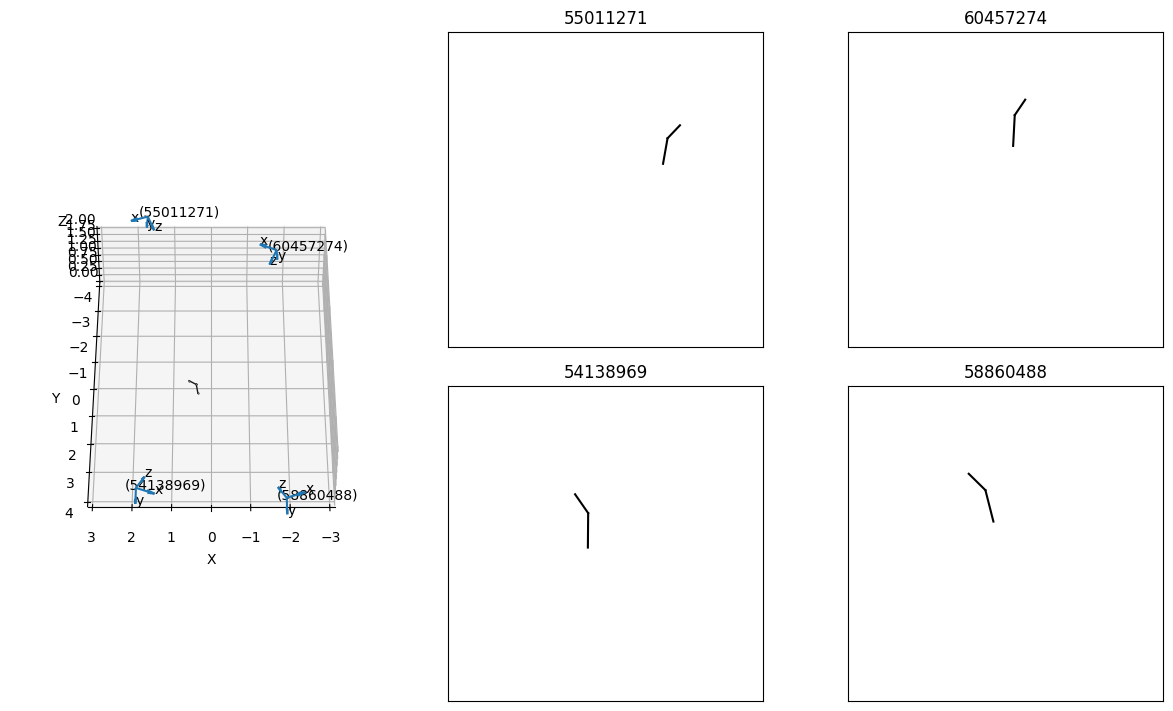

In [35]:
frame_num = 100
cam_id = '54138969'
limb = limb_trajectory[frame_num]

plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout(h_pad=-1, w_pad=-1)

%matplotlib inline
fig = plt.figure(0, figsize=(12, 7), layout='constrained')
fig.clear()
axd = fig.subplot_mosaic(
    """
    ABC
    ADE
    """,
    per_subplot_kw={('A'): {'projection': '3d'}}
)
axA = axes_3d(ax=axd['A'], xlim=(-3, 3), ylim=(-4, 4), zlim=(0, 2), view=(45, 90))
axB = axes_2d(ax=axd['B'], H=1000, W=1000, show_axis=False)
axC = axes_2d(ax=axd['C'], H=1000, W=1000, show_axis=False)
axD = axes_2d(ax=axd['D'], H=1000, W=1000, show_axis=False)
axE = axes_2d(ax=axd['E'], H=1000, W=1000, show_axis=False)

axB.set_title('55011271')
axC.set_title('60457274')
axD.set_title('54138969')
axE.set_title('58860488')


draw_3d_pose(axA, limb, dataset='limb')
fig.sca(axA)
cam_param['54138969']['frame'].draw3d()
cam_param['55011271']['frame'].draw3d()
cam_param['58860488']['frame'].draw3d()
cam_param['60457274']['frame'].draw3d()


draw_2d_pose(axD, limb_trajectory_projected1[frame_num], H=1000, W=1000, dataset='limb') # '54138969'
draw_2d_pose(axB, limb_trajectory_projected2[frame_num], H=1000, W=1000, dataset='limb') # '55011271'
draw_2d_pose(axE, limb_trajectory_projected3[frame_num], H=1000, W=1000, dataset='limb') # '58860488'
draw_2d_pose(axC, limb_trajectory_projected4[frame_num], H=1000, W=1000, dataset='limb') # '60457274'

plt.show()

In [17]:
cam_param[camera_id]['int'], cam_param[camera_id]['ext']

({'calibration_matrix': [[1145.51133842318, 0.0, 514.968197319863],
   [0.0, 1144.77392807652, 501.882018537695],
   [0.0, 0.0, 1.0]],
  'distortion': [-0.198384093827848,
   0.218323676298049,
   -0.00181336200488089,
   -0.000587205583421232,
   -0.00894780704152122]},
 {'R': [[0.9141562410494211, -0.40060705854636447, 0.061905989962380774],
   [-0.05641000739510571, -0.2769531972942539, -0.9592261660183036],
   [0.40141783470104664, 0.8733904688919611, -0.2757767409202658]],
  't': [[51.88347637559197], [378.4208425426766], [4406.149140878431]]})

In [26]:
camera_id = '54138969'

data = {}
for key in ['joint_2d', 'confidence', 'joint3d_image', 'joints_2.5d_image', '2.5d_factor', 'camera_name', 'action', 'source', 'frame', 'world_3d', 'cam_3d', 'cam_param']:
    data[key] = []

calibration_matrix = np.array(cam_param[camera_id]['int']['calibration_matrix'])
R = np.array(cam_param[camera_id]['ext']['R'])
t = np.array(cam_param[camera_id]['ext']['t']) * 0.001
camera_param = {
    'intrinsic': calibration_matrix,
    'extrinsic': np.concatenate([R, t.reshape(3, 1)], axis=1),
}

fx = camera_param['intrinsic'][0, 0]  
fy = camera_param['intrinsic'][1, 1]  
cx = camera_param['intrinsic'][0, 2]  
cy = camera_param['intrinsic'][1, 2] 

for frame_num in tqdm(range(len(limb_trajectory))):
    # joint3d_image
    world_3d = np.array(limb_trajectory[frame_num])

    # world to camera
    pos = copy.deepcopy(world_3d)
    cam_3d = World2CameraCoordinate(pos, camera_param['extrinsic']) # World coordinate -> Camera coordinate
    cam_3d_hat = get_rootrel_pose(cam_3d)

    # camera to image
    box = infer_box(cam_3d, {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0)
    img_2d, img_3d = camera_to_image_frame(cam_3d, box, {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0) 
    #img_2d_hat = get_rootrel_pose(img_2d) # (17, 2) # root-relative pose 
    img_3d_hat = get_rootrel_pose(img_3d) # (17, 3) # root-relative pose 

    # 2.5d factor
    pred_lambda, losses = optimize_scaling_factor(img_3d_hat, cam_3d_hat, stop_tolerance=0.0001) # x,y,z 사용
    #print('pred_lambda:', pred_lambda)
    #print('losses:', losses)

    # joint 2.5d image
    img_25d = img_3d * pred_lambda
    #img_25d_hat = get_rootrel_pose(img_25d)

    # store
    data['joint_2d'].append(np.array(img_2d).copy()) 
    data['confidence'].append(np.ones(17)) 
    data['joint3d_image'].append(np.array(img_3d).copy()) 
    data['joints_2.5d_image'].append(np.array(img_25d).copy()) 
    data['2.5d_factor'].append(np.array(pred_lambda).copy()) 
    data['camera_name'].append(np.array(camera_id).copy()) 
    data['action'].append(np.array(action).copy()) 
    #data['source'].append(np.array(source).copy()) 
    data['frame'].append(np.array(frame_num).copy()) 
    data['world_3d'].append(np.array(world_3d).copy()) 
    data['cam_3d'].append(np.array(cam_3d).copy()) 
    data['cam_param'].append(np.array(camera_param).copy()) 

100%|██████████| 243/243 [00:01<00:00, 122.38it/s]


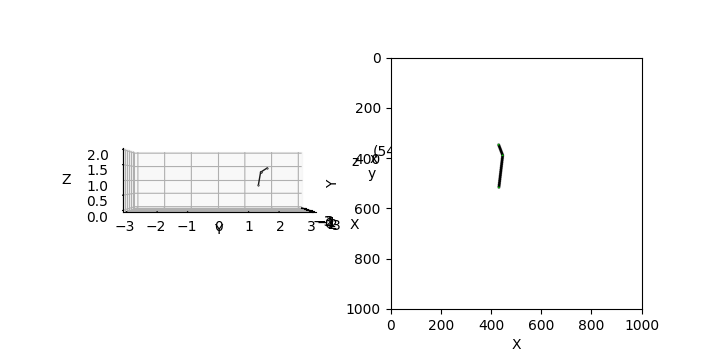

In [27]:
%matplotlib widget
fig = plt.figure(3)
fig.clear()
ax = axes_3d(fig, loc=121,
             xlim=(-3, 3), ylim=(-3, 3), zlim=(0, 2))
ax.set_zlim(0, 2)
ax.set_aspect('equal', 'box')
draw_3d_pose(ax, world_3d, dataset='limb')
draw_3d_pose(ax, img_3d, dataset='limb')

cam_id = '54138969'
cam_param[camera_id]['frame'].draw3d()
ax2 = axes_2d(fig, loc=122)
img = get_2d_pose_image(img_2d, H=1000, W=1000, dataset='limb')
ax2.imshow(img)
ax2.plot(box[0], box[1], 'r-')
plt.show()

### generate pkl for each sample

In [10]:
# sampling 
seed = 0
random.seed(seed)
total_num_data = 10000

camera_param = {}
for camera_id in ['54138969', '55011271', '58860488', '60457274']:
    calibration_matrix = np.array(cam_param[camera_id]['int']['calibration_matrix'])
    R = np.array(cam_param[camera_id]['ext']['R'])
    t = np.array(cam_param[camera_id]['ext']['t']) * 0.001
    camera_param[camera_id] = {
        'intrinsic': calibration_matrix,
        'extrinsic': np.concatenate([R, t.reshape(3, 1)], axis=1),
        'fx': calibration_matrix[0, 0],
        'fy': calibration_matrix[1, 1],
        'cx': calibration_matrix[0, 2],
        'cy': calibration_matrix[1, 2],
    }

save_folder = '/home/hrai/codes/MotionBERT/data/motion3d/random_limb_pkl'
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

for i in tqdm(range(total_num_data)):
    save_path = save_folder + '/seed{}_{}.pkl'.format(seed, i)

    data = {}
    for key in ['joint_2d', 'confidence', 'joint3d_image', 'joints_2.5d_image', '2.5d_factor', 'camera_name', 'action', 'source', 'frame', 'world_3d', 'cam_3d', 'cam_param']:
        data[key] = []

    root_point_traj_num = random.randint(0, len(root_point_traj_list)-1)
    upper_vector_traj_num = random.randint(0, len(upper_vector_traj_list)-1)
    under_vector_traj_num = random.randint(0, len(under_vector_traj_list)-1)

    root_point_start_idx = random.randint(0, len(root_point_traj_list)-243)
    upper_vector_start_idx = random.randint(0, len(upper_vector_traj_list)-243)
    under_vector_start_idx = random.randint(0, len(under_vector_traj_list)-243)

    if os.path.exists(save_path): continue # locate here to keep the randoom seed consistent

    root_point_traj = root_point_traj_list[root_point_traj_num][root_point_start_idx:root_point_start_idx+243]
    upper_vector_traj = upper_vector_traj_list[upper_vector_traj_num][upper_vector_start_idx:upper_vector_start_idx+243] + root_point_traj
    under_vector_traj = under_vector_traj_list[under_vector_traj_num][under_vector_start_idx:under_vector_start_idx+243] + upper_vector_traj

    limb_trajectory = np.stack([root_point_traj, upper_vector_traj, under_vector_traj], axis=1)
    
    for camera_id in ['54138969', '55011271', '58860488', '60457274']:
        fx = camera_param[camera_id]['fx']
        fy = camera_param[camera_id]['fy']
        cx = camera_param[camera_id]['cx']
        cy = camera_param[camera_id]['cy']
        for frame_num in range(len(limb_trajectory)):
            # joint3d_image
            world_3d = np.array(limb_trajectory[frame_num])

            # world to camera
            pos = copy.deepcopy(world_3d)
            cam_3d = World2CameraCoordinate(pos, camera_param[camera_id]['extrinsic']) # World coordinate -> Camera coordinate
            cam_3d_hat = get_rootrel_pose(cam_3d)

            # camera to image
            box = infer_box(cam_3d, {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0)
            img_2d, img_3d = camera_to_image_frame(cam_3d, box, {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0) 
            #img_2d_hat = get_rootrel_pose(img_2d) # (3, 2) # root-relative pose 
            img_3d_hat = get_rootrel_pose(img_3d) # (3, 3) # root-relative pose 

            # 2.5d factor
            pred_lambda, losses = optimize_scaling_factor(img_3d_hat, cam_3d_hat, stop_tolerance=0.0001) # x,y,z 사용

            # joint 2.5d image
            img_25d = img_3d * pred_lambda
            #img_25d_hat = get_rootrel_pose(img_25d)

            source = 'seed{}_{}'.format(seed, i)

            # store
            data['joint_2d'].append(np.array(img_2d).copy()) 
            data['confidence'].append(np.ones(3)) 
            data['joint3d_image'].append(np.array(img_3d).copy()) 
            data['joints_2.5d_image'].append(np.array(img_25d).copy()) 
            data['2.5d_factor'].append(np.array(pred_lambda).copy()) 
            data['camera_name'].append(np.array(camera_id).copy()) 
            data['action'].append(np.array(action).copy()) 
            data['source'].append(np.array(source).copy()) 
            data['frame'].append(np.array(frame_num).copy()) 
            data['world_3d'].append(np.array(world_3d).copy()) 
            data['cam_3d'].append(np.array(cam_3d).copy()) 
            data['cam_param'].append(np.array(camera_param[camera_id]).copy()) 

    # save
    savepkl(data, save_path)

  0%|          | 0/10000 [00:00<?, ?it/s]

 40%|████      | 4000/10000 [12:38:24<18:57:36, 11.38s/it]


KeyboardInterrupt: 

### Check pkls by generating videos

In [11]:
for item in glob('/home/hrai/codes/MotionBERT/data/motion3d/random_limb_pkl/seed*_*.pkl'):
    data = readpkl(item)
    seed = int(item.split('/')[-1].split('_')[0][4:])
    num = int(item.split('/')[-1].split('_')[1].split('.')[0])
    print(seed, num)
    video_path = '/home/hrai/codes/MotionBERT/custom_codes/DHDST/seed{}_{}.mp4'.format(seed, num)
    if os.path.exists(video_path): continue
    print(np.array(data['joint_2d']).shape)
    save_h36m_pose_video(np.array(data['joint_2d']), video_path, dataset='limb', W=1000, H=1000, pose_type='2d', fps=30,
                            xlim=(-1, 1), ylim=(-1, 1), zlim=(0, 2), view=(0, 45),
                            centered_xy=False, cam_space=False, on_ground=False, refine_tilt=False,  
                            dynamic_view=False, dual_view=False,
                            imgs=None,
                            show_axis=False)

0 1620
(972, 3, 2)


  0%|          | 0/972 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6617b40] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 972/972 [00:10<00:00, 91.85it/s] 


0 546
(972, 3, 2)


  0%|          | 0/972 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6bfcb40] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 972/972 [00:10<00:00, 93.02it/s] 


0 1222
(972, 3, 2)


  0%|          | 0/972 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6741b40] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 972/972 [00:09<00:00, 99.47it/s] 


0 1296
(972, 3, 2)


  0%|          | 0/972 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5e00b40] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 972/972 [00:10<00:00, 89.86it/s] 


0 1509
(972, 3, 2)


  0%|          | 0/972 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6646b40] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 972/972 [00:10<00:00, 96.60it/s] 


0 359
(972, 3, 2)


  0%|          | 0/972 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x633db40] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 972/972 [00:10<00:00, 89.56it/s] 


0 1209
(972, 3, 2)


  0%|          | 0/972 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x59d3b40] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 972/972 [00:10<00:00, 91.97it/s] 


0 2009
(972, 3, 2)


  0%|          | 0/972 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7262b40] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 972/972 [00:10<00:00, 94.52it/s] 


0 3926
(972, 3, 2)


  0%|          | 0/972 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7468b40] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 972/972 [00:10<00:00, 90.42it/s] 


0 2952
(972, 3, 2)


  0%|          | 0/972 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5ce6b40] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 972/972 [00:10<00:00, 94.26it/s] 


0 3069
(972, 3, 2)


  0%|          | 0/972 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5727b40] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 972/972 [00:10<00:00, 96.24it/s] 


0 799
(972, 3, 2)


  0%|          | 0/972 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x585fb40] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 972/972 [00:10<00:00, 96.78it/s] 


0 2918
(972, 3, 2)


  0%|          | 0/972 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5a60b40] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 972/972 [00:10<00:00, 93.59it/s] 


0 3337
(972, 3, 2)


  0%|          | 0/972 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x570cb40] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 972/972 [00:10<00:00, 93.78it/s] 


0 2574
(972, 3, 2)


  0%|          | 0/972 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5d36b40] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 972/972 [00:10<00:00, 93.16it/s] 


0 3479
(972, 3, 2)


  0%|          | 0/972 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x65bfb40] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 972/972 [00:10<00:00, 93.26it/s] 


0 205
(972, 3, 2)


  0%|          | 0/972 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6e9eb40] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 972/972 [00:10<00:00, 93.99it/s] 


0 2709
(972, 3, 2)


  0%|          | 0/972 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x61eeb40] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 972/972 [00:10<00:00, 94.51it/s] 


0 2188
(972, 3, 2)


  0%|          | 0/972 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7042b40] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 972/972 [00:10<00:00, 90.47it/s] 


0 1316
(972, 3, 2)


  0%|          | 0/972 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x70a1b40] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 972/972 [00:10<00:00, 92.22it/s] 
/home/hrai/codes/PoseAdaptor/my_utils/visualization.py:451: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


0 1686
(972, 3, 2)


  0%|          | 0/972 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x60cbb40] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 972/972 [00:10<00:00, 92.76it/s] 


0 3080
(972, 3, 2)


  0%|          | 0/972 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5fabb40] Warning: data is not aligned! This can lead to a speed loss
 91%|█████████ | 881/972 [00:09<00:01, 89.41it/s] Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f53231c6fd0>>
Traceback (most recent call last):
  File "/home/hrai/miniconda3/envs/motionbert/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
100%|██████████| 972/972 [00:10<00:00, 92.00it/s] 


0 587
(972, 3, 2)


  0%|          | 0/972 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6a8ab40] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 972/972 [00:10<00:00, 94.97it/s] 


0 637
(972, 3, 2)


  0%|          | 0/972 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x554ab40] Warning: data is not aligned! This can lead to a speed loss
 23%|██▎       | 226/972 [00:02<00:07, 103.47it/s]

### generate total pkl

In [7]:
# split train/test 
pkl_folder = '/home/hrai/codes/MotionBERT/data/motion3d/random_limb_pkl/'
random.seed(0)
l = [x for x in range(len(os.listdir(pkl_folder)))][:2000]
random.shuffle(l)
train_list = l[:int(len(l)*0.8)]
test_list = l[int(len(l)*0.8):]
print(len(train_list), len(test_list), train_list[:5], test_list[:5])

1600 400 [1748, 1361, 1671, 865, 1288] [390, 200, 1921, 1082, 1383]


In [11]:
joint_2ds = {'train': [], 'test': []}
confidences = {'train': [], 'test': []}
joint3d_images = {'train': [], 'test': []}
joints_25d_images = {'train': [], 'test': []}
_25d_factors = {'train': [], 'test': []}
camera_names = {'train': [], 'test': []}
actions = {'train': [], 'test': []}
sources = {'train': [], 'test': []}
frames = {'train': [], 'test': []}
world_3ds = {'train': [], 'test': []}
cam_3ds = {'train': [], 'test': []}
cam_params = {'train': [], 'test': []}

# target 

#action_list = ['squat', 'pushup', 'kneeup', 'benchpress', 'burpee', 'cat', 'yoga']
#test_subject = ['S12', 'S15', 'S18'] # ['S01', 'S02', 'S03', 'S04', 'S05', 'S06', 'S07', 'S08', 'S09', 'S10']
#camera_list = [1, 2, 3, 4, 5] # [1, 2, 3, 4, 5]
# pelvis, r_hip, l_hip, torso, neck, l_shoulder, r_shoulder = 0, 1, 4, 7, 8, 11, 14
# r_knee, r_ankle, l_knee, l_ankle = 2, 3, 5, 6
# l_elbow, l_wrist, r_elbow, r_wrist = 12, 13, 15, 16
# joint_list = [j for j in range(17)] # [r_knee, r_ankle, l_knee, l_ankle, l_elbow, l_wrist, r_elbow, r_wrist] # [j for j in range(17)]
only_test = False

blacklist = []

for item in tqdm(os.listdir(pkl_folder)):
    seed, num = item.split('.')[0].split('seed')[1].split('_')
    #print(seed, num)
    # filtering
    #if action not in action_list: continue 
    #if int(cam_num) not in camera_list: continue
    #if only_test:
    #    if subject not in test_subject: continue
    #if subject in blacklist: continue
    #print(subject, cam_num, action, phase) 
    
    if int(num) in test_list: data_type = 'test'
    elif int(num) in train_list: data_type = 'train'
    else: continue 
    
    item_path = os.path.join(pkl_folder, item) 
    data = readpkl(item_path) 
    
    joint_2ds[data_type] += list(np.array(data['joint_2d'])) 
    confidences[data_type] += list(np.array(data['confidence'])) 
    joint3d_images[data_type] += list(np.array(data['joint3d_image'])) 
    joints_25d_images[data_type] += list(np.array(data['joints_2.5d_image'])) 
    _25d_factors[data_type] += data['2.5d_factor'] 
    camera_names[data_type] += data['camera_name']  
    actions[data_type] += data['action'] 
    sources[data_type] += data['source'] 
    frames[data_type] += data['frame'] 
    world_3ds[data_type] += list(np.array(data['world_3d'])) 
    cam_3ds[data_type] += list(np.array(data['cam_3d']))
    cam_params[data_type] += data['cam_param'] 
    
kookmin_total = {'train': {}, 'test': {}}

for data_type in ['train', 'test']:
    kookmin_total[data_type]['joint_2d']          = copy.deepcopy(np.array(joint_2ds[data_type]))
    kookmin_total[data_type]['confidence']        = copy.deepcopy(np.array(confidences[data_type]))
    kookmin_total[data_type]['joint3d_image']     = copy.deepcopy(np.array(joint3d_images[data_type]))
    kookmin_total[data_type]['joints_2.5d_image'] = copy.deepcopy(np.array(joints_25d_images[data_type]))
    kookmin_total[data_type]['2.5d_factor']       = copy.deepcopy(np.array(_25d_factors[data_type]))
    kookmin_total[data_type]['camera_name']       = copy.deepcopy(np.array(camera_names[data_type]))
    kookmin_total[data_type]['action']            = copy.deepcopy(np.array(actions[data_type]))
    kookmin_total[data_type]['source']            = copy.deepcopy(np.array(sources[data_type]))
    kookmin_total[data_type]['frame']             = copy.deepcopy(np.array(frames[data_type]))
    kookmin_total[data_type]['world_3d']          = copy.deepcopy(np.array(world_3ds[data_type]))
    kookmin_total[data_type]['cam_3d']            = copy.deepcopy(np.array(cam_3ds[data_type]))
    kookmin_total[data_type]['cam_param']         = copy.deepcopy(np.array(cam_params[data_type]))
    
# if len(kookmin_total['train']['joint_2d']) == 0:
#     kookmin_total['train'] = copy.deepcopy(kookmin_total['test'])

kookmin_total['train']['joint3d_image'].shape, kookmin_total['test']['joint3d_image'].shape  

100%|██████████| 4000/4000 [00:49<00:00, 80.11it/s] 


((1555200, 3, 3), (388800, 3, 3))

In [12]:
kookmin_total['test']['confidence'].shape, kookmin_total['test']['source'].shape

((388800, 3), (388800,))

In [13]:
user = getpass.getuser()
motionbert_root = '/home/{}/codes/MotionBERT'.format(user)
save_path = os.path.join(motionbert_root, 'data/motion3d/random_limb_train{}_test{}.pkl'.format(len(train_list), len(test_list)))
savepkl(kookmin_total, save_path)

In [15]:
kookmin_total['train'].keys()

dict_keys(['joint_2d', 'confidence', 'joint3d_image', 'joints_2.5d_image', '2.5d_factor', 'camera_name', 'action', 'source', 'frame', 'world_3d', 'cam_3d', 'cam_param'])

In [16]:
kookmin_total['train']['joints_2.5d_image'][0]

array([[1.92123161, 1.35774198, 0.        ],
       [1.95684887, 1.85142271, 0.08006528],
       [1.81702749, 2.26153837, 0.2461267 ]])

In [19]:
1/kookmin_total['train']['2.5d_factor'][0]

237.21360842147308

In [20]:
kookmin_total['train']['joints_2.5d_image'][0] / kookmin_total['train']['2.5d_factor'][0]

array([[455.74228318, 322.07487359,   0.        ],
       [464.19118122, 439.18266141,  18.99257455],
       [431.02364755, 536.46767742,  58.38460334]])

In [17]:
kookmin_total['train']['joint3d_image'][0]

array([[455.74228318, 322.07487359,   0.        ],
       [464.19118122, 439.18266141,  18.99257455],
       [431.02364755, 536.46767742,  58.38460334]])